In [ ]:
!pip install seaborn

In [ ]:
!pip install optuna

In [1]:
import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv("../data/raw/term-deposit-marketing-2020.csv")
print(len(df))
print(df.head())

40000
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign   y  
0  unknown    5   may       261         1  no  
1  unknown    5   may       151         1  no  
2  unknown    5   may        76         1  no  
3  unknown    5   may        92         1  no  
4  unknown    5   may       198         1  no  


In [4]:
# Add a unique identifier to df for DataFrame Management and merging

df['customer_id'] = df.index

In [5]:
print(len(df))
print(df.head())

40000
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign   y  customer_id  
0  unknown    5   may       261         1  no            0  
1  unknown    5   may       151         1  no            1  
2  unknown    5   may        76         1  no            2  
3  unknown    5   may        92         1  no            3  
4  unknown    5   may       198         1  no            4  


In [6]:
# Change data in the data frame to have numerical values for all the features binary
# Use one hot encoding to create new binary features

# Mapping for binary features
binary_columns = {
    'default': {'no': 0, 'yes': 1},
    'housing': {'no': 0, 'yes': 1},
    'loan': {'no': 0, 'yes': 1},
    'y': {'no': 0, 'yes': 1}
}
# Apply the mapping to convert binary columns
for column, mapping in binary_columns.items():
    df[column] = df[column].map(mapping)

# One-hot encode the specified columns
one_hot_columns = ['job', 'contact', 'marital']
df = pd.get_dummies(df, columns=one_hot_columns, drop_first=True)  # Avoid dummy variable trap by dropping the first column

# Ordinal encoding for education
education_mapping = {'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3}
df['education'] = df['education'].map(education_mapping)

# Ordinal encoding for month
month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
df['month'] = df['month'].map(month_mapping)

# Display the updated dataset to confirm changes
print("\nUpdated dataset df with binary features converted to 0s and 1s, One Hot encoding and Ordinal encoding:\n")
print(len(df))
print(df.head())


Updated dataset df with binary features converted to 0s and 1s, One Hot encoding and Ordinal encoding:

40000
   age  education  default  balance  housing  loan  day  month  duration  \
0   58          3        0     2143        1     0    5      5       261   
1   44          2        0       29        1     0    5      5       151   
2   33          2        0        2        1     1    5      5        76   
3   47          0        0     1506        1     0    5      5        92   
4   33          0        0        1        0     0    5      5       198   

   campaign  ...  job_self-employed  job_services  job_student  \
0         1  ...              False         False        False   
1         1  ...              False         False        False   
2         1  ...              False         False        False   
3         1  ...              False         False        False   
4         1  ...              False         False        False   

   job_technician  job_unemployed  

## Create Demographic and Fianacial data frame

In [7]:
# Remove campaign related features
#     This will hel us identify the TYPE of person most likely to sign up for term deposits regardles of past campaign activity

df_demographic = df.drop(columns=['day', 'month', 'duration','campaign',])

print(len(df_demographic))
print(df_demographic.head())

40000
   age  education  default  balance  housing  loan  y  customer_id  \
0   58          3        0     2143        1     0  0            0   
1   44          2        0       29        1     0  0            1   
2   33          2        0        2        1     1  0            2   
3   47          0        0     1506        1     0  0            3   
4   33          0        0        1        0     0  0            4   

   job_blue-collar  job_entrepreneur  ...  job_self-employed  job_services  \
0            False             False  ...              False         False   
1            False             False  ...              False         False   
2            False              True  ...              False         False   
3             True             False  ...              False         False   
4            False             False  ...              False         False   

   job_student  job_technician  job_unemployed  job_unknown  \
0        False           False           

In [8]:
# automatically ignore 'customer_id' as a feature
print(df_demographic.columns.tolist())

df_demographic.set_index('customer_id', inplace=True)

['age', 'education', 'default', 'balance', 'housing', 'loan', 'y', 'customer_id', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'contact_telephone', 'contact_unknown', 'marital_married', 'marital_single']


## Train model for df_demographic

In [9]:
# Split the data for training and testing for df_demogrpahic (data frame layer 1) on Deomgrphic features only

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, classification_report

X = df_demographic.drop(columns=['y'])  # Features
y = df_demographic['y']  # binary: who signed up for term deposits so far

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Check class distribution before SMOTE
print("\nBefore SMOTE:", Counter(y_train))

# Apply SMOTE to balance the training dataset with sythetic data for y
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("\nAfter SMOTE:", Counter(y_train_balanced))

# Train the model without the best parameters (using default or basic parameters)
demographic_model = RandomForestClassifier(
    n_estimators=100,    # Default value: number of trees
    max_depth=None,      # Default value: no limit on the depth of the tree
    min_samples_split=5, # 5 to guard against overfitting
    min_samples_leaf=2,  # 2 help the model with generalization
    random_state=42      # Ensures reproducibility of results
)

# Perform cross-validation with multiple metrics
scoring_metrics = ['roc_auc', 'recall', 'precision', 'f1', 'accuracy']

# Perform cross-validation
cv_results = cross_validate(demographic_model, X_train_balanced, y_train_balanced, cv=5, scoring=scoring_metrics, return_train_score=True)

# Print results for each metric
for metric in scoring_metrics:
    print(f"\nCross-validation {metric.upper()}: {cv_results['test_' + metric].mean():.4f} (+/- {cv_results['test_' + metric].std():.4f})")




Before SMOTE: Counter({0: 29683, 1: 2317})

After SMOTE: Counter({0: 29683, 1: 29683})

Cross-validation ROC_AUC: 0.9608 (+/- 0.0466)

Cross-validation RECALL: 0.9116 (+/- 0.1145)

Cross-validation PRECISION: 0.9144 (+/- 0.0105)

Cross-validation F1: 0.9097 (+/- 0.0679)

Cross-validation ACCURACY: 0.9138 (+/- 0.0566)


In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=50)
    max_depth = trial.suggest_int('max_depth', 5, 50, step=5)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', {0: 1, 1: 3}, {0: 1, 1: 5}])  

    # Train RandomForest with suggested parameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight=class_weight,
        random_state=42
    )

    # Use cross-validation to evaluate Recall
    recall = cross_val_score(model, X_train_balanced, y_train_balanced, scoring='recall', cv=5).mean()
    
    return recall  # Optuna will maximize this metric

# Run Optuna optimization
study = optuna.create_study(direction='maximize')  # Maximize Recall
study.optimize(objective, n_trials=100)  # Adjust trials as needed

# Print best parameters
print("Best Parameters for Recall:", study.best_params)

# Train the best model
best_params = study.best_params
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train_balanced, y_train_balanced)

# Evaluate on test data
y_pred = best_model.predict(X_test)


In [ ]:
# Get the Recal for the Optuna hypertuned model on the test set

from sklearn.metrics import recall_score

y_pred = best_model.predict(X_test)
recall_test = recall_score(y_test, y_pred)

print("Final Recall on Test Set:", recall_test)


## Recall was better before hypertuning so keep orginal model (demographic_model) as layer 1 model 

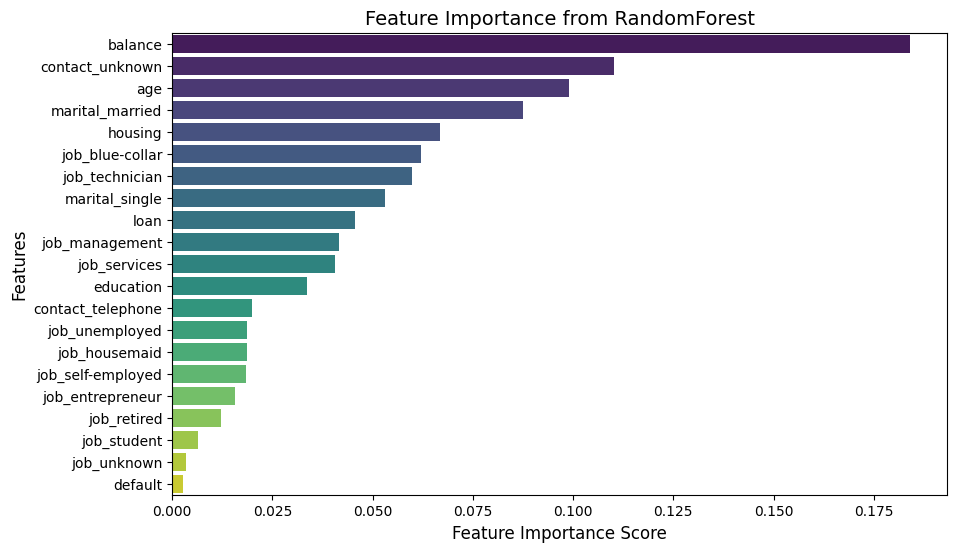

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Train the model on balanced data
demographic_model.fit(X_train_balanced, y_train_balanced)

# Extract feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train_balanced.columns,
    'Importance': demographic_model.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, hue='Feature', palette="viridis", legend=False)

# Add labels
plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importance from RandomForest", fontsize=14)

plt.show()


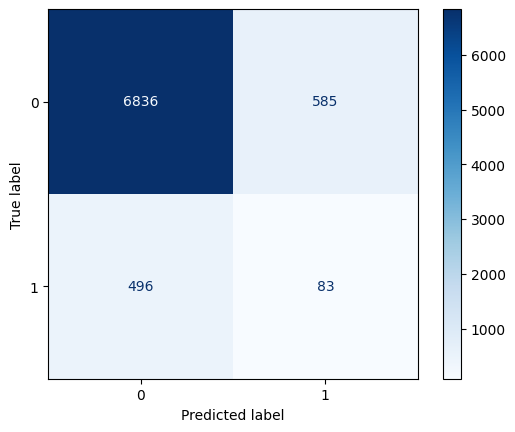

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Train the model on the full training data
demographic_model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred = demographic_model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix visually
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=demographic_model.classes_)
disp.plot(cmap="Blues")  # You can change the color scheme if you prefer


ROC AUC: 0.9609

*   The model performs well in distinguishing between sign-ups and non-sign-ups (0.9893 → 0.9609)

Precision: 0.9150

*   When the model predicts a customer will sign up, it is correct 91.5% of the time.

Recall: 0.9126

*   The model captures 91.3% of actual sign-ups (0.9447)

F1 Score: 0.9105

*   balanced measure of precision and recall

Accuracy: 0.9146

*   The model correctly classifies customers 91.5% of the time.



Confusion Matrix Analysis

*   Actual Sign-Up (1)	6857 (TP)	564 (FN)
*   Actual No Sign-Up (0)	493 (FP)	86 (TN)

The model does poorly at correctly predicting non-sign-ups (y=0), reinforcing its bias towards predicting sign-ups.

Predicted Sign-Up (1)	Predicted No Sign-Up (0)

Key Takeaways

*   Bias towards predicting sign-ups remains, with very few correctly predicted non-sign-ups (TN = 86).
*   If the goal is to prioritize outreach to high-probability customers, the model remains useful.

In [12]:
# Obtain Probability Scores for signing up based on demographic and fiancial features
# Predict on X real data not the balanced sythetic data from SMOTE used for training

demographic_probs = demographic_model.predict_proba(X)[:, 1]  # Probability of signing up
df_demographic['sign_up_probability'] = demographic_probs

# Reset index to ensure customer_id is a column before filtering
df_demographic = df_demographic.reset_index()

print(len(df_demographic))
print(df_demographic.head())

40000
   customer_id  age  education  default  balance  housing  loan  y  \
0            0   58          3        0     2143        1     0  0   
1            1   44          2        0       29        1     0  0   
2            2   33          2        0        2        1     1  0   
3            3   47          0        0     1506        1     0  0   
4            4   33          0        0        1        0     0  0   

   job_blue-collar  job_entrepreneur  ...  job_services  job_student  \
0            False             False  ...         False        False   
1            False             False  ...         False        False   
2            False              True  ...         False        False   
3             True             False  ...         False        False   
4            False             False  ...         False        False   

   job_technician  job_unemployed  job_unknown  contact_telephone  \
0           False           False        False              False   
1 

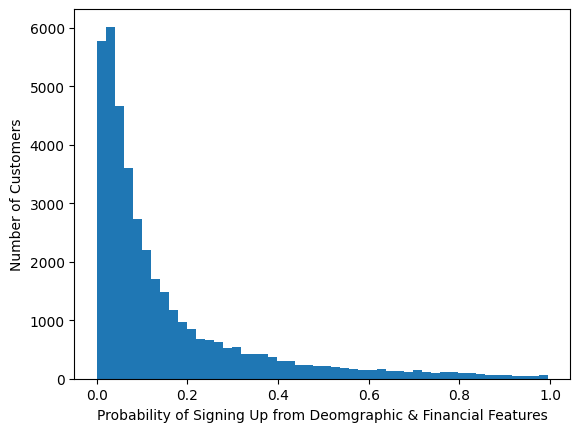

count    40000.000000
mean         0.154256
std          0.187461
min          0.000442
25%          0.033850
50%          0.079706
75%          0.192273
max          0.995390
Name: sign_up_probability, dtype: float64

In [13]:
# check distributions of probabilities

import matplotlib.pyplot as plt
plt.hist(demographic_probs, bins=50)
plt.xlabel("Probability of Signing Up from Deomgraphic & Financial Features")
plt.ylabel("Number of Customers")
plt.show()

df_demographic['sign_up_probability'].describe()


In [14]:
# Find the probability score corresponding to the top 30% or 50% of customers.

percentile_30 = np.percentile(demographic_probs, 70)  # Keep top 30%
percentile_50 = np.percentile(demographic_probs, 50)  # Keep top 50%

print(f"Probability cutoff for top 30%: {percentile_30:.4f}")
print(f"Probability cutoff for top 50%: {percentile_50:.4f}")


Probability cutoff for top 30%: 0.1574
Probability cutoff for top 50%: 0.0797


In [15]:
# Find the probability distribution of actual sign-ups (y=1):

import pandas as pd

# Filter only customers who actually signed up
sign_ups = df_demographic[df_demographic['y'] == 1]['sign_up_probability']

# Find the probability threshold where 90%, 50% and 20% of actual past sign-ups were above
threshold_90 = np.percentile(sign_ups, 10)  # Bottom 10% of sign-ups
threshold_50 = np.percentile(sign_ups, 50)  #
threshold_20 = np.percentile(sign_ups, 80)  #

print(f"Probability cutoff where 90% of actual past sign-ups were above: {threshold_90:.4f}")
print(f"Probability cutoff where 50% of actual past sign-ups were above: {threshold_50:.4f}")
print(f"Probability cutoff where 20% of actual past sign-ups were above: {threshold_20:.4f}")

Probability cutoff where 90% of actual past sign-ups were above: 0.1431
Probability cutoff where 50% of actual past sign-ups were above: 0.3730
Probability cutoff where 20% of actual past sign-ups were above: 0.6801


In [16]:
# Preparation of data frames with different levels of targeted approach
# Keep only customers with targeted sign-up probabilities for different levels of targeted approach

df_demographic_top50 = df_demographic[df_demographic['sign_up_probability'] >= 0.0797]
df_demographic_90 = df_demographic[df_demographic['sign_up_probability'] >= 0.1431]
df_demographic_50 = df_demographic[df_demographic['sign_up_probability'] >= 0.3730]
df_demographic_20 = df_demographic[df_demographic['sign_up_probability'] >= 0.6801]

# Ensure we exclude customers who have already signed up
df_demographic_top50 = df_demographic_top50[df_demographic_top50['y'] == 0]
df_demographic_90 = df_demographic_90[df_demographic_90['y'] == 0]
df_demographic_50 = df_demographic_50[df_demographic_50['y'] == 0]
df_demographic_20 = df_demographic_20[df_demographic_20['y'] == 0]

# Display the size of the filtered dataset
print(f"Remaining customers for Layer 2 for top 50%: {len(df_demographic_top50)}")
print(f"Remaining customers for Layer 2 for top 90% of known past sign ups: {len(df_demographic_90)}")
print(f"Remaining customers for Layer 2 for top 50% of known past sign ups: {len(df_demographic_50)}")
print(f"Remaining customers for Layer 2 for top 20% of known past sign ups: {len(df_demographic_20)}")


Remaining customers for Layer 2 for top 50%: 17278
Remaining customers for Layer 2 for top 90% of known past sign ups: 10447
Remaining customers for Layer 2 for top 50% of known past sign ups: 3200
Remaining customers for Layer 2 for top 20% of known past sign ups: 789


In [17]:
# I look at the distributions of the sign-up probabilities for the different levels of targeted approach

print(df_demographic_top50.columns.tolist())
print(df_demographic_top50['sign_up_probability'].describe())
print()
print(df_demographic_90.columns.tolist())
print(df_demographic_90['sign_up_probability'].describe())
print()
print(df_demographic_50.columns.tolist())
print(df_demographic_50['sign_up_probability'].describe())
print()
print(df_demographic_20.columns.tolist())
print(df_demographic_20['sign_up_probability'].describe())
print()



['customer_id', 'age', 'education', 'default', 'balance', 'housing', 'loan', 'y', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'contact_telephone', 'contact_unknown', 'marital_married', 'marital_single', 'sign_up_probability']
count    17278.000000
mean         0.242078
std          0.183015
min          0.079703
25%          0.114119
50%          0.169747
75%          0.302804
max          0.995390
Name: sign_up_probability, dtype: float64

['customer_id', 'age', 'education', 'default', 'balance', 'housing', 'loan', 'y', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'contact_telephone', 'contact_unknown', 'marital_married', 'marital_single', 'sign_up_probability']
count    10447.000000
mean       

In [18]:
# Merge each filtered demographic dataset with df campaign features to retain only relevant customers and their campaign data only
# Here we are preparing these filtered demographic lists to be used on the layer 2 model

df_top50_layer2 = df[df['customer_id'].isin(df_demographic_top50['customer_id'])][['day', 'month', 'duration', 'campaign', 'y', 'customer_id']]
df_top50_layer2 = df_top50_layer2.merge(df_demographic[['customer_id', 'sign_up_probability']], on='customer_id', how='left')

df_90_layer2 = df[df['customer_id'].isin(df_demographic_90['customer_id'])][['day', 'month', 'duration', 'campaign', 'y', 'customer_id']]
df_90_layer2 = df_90_layer2.merge(df_demographic[['customer_id', 'sign_up_probability']], on='customer_id', how='left')

df_50_layer2 = df[df['customer_id'].isin(df_demographic_50['customer_id'])][['day', 'month', 'duration', 'campaign', 'y', 'customer_id']]
df_50_layer2 = df_50_layer2.merge(df_demographic[['customer_id', 'sign_up_probability']], on='customer_id', how='left')

df_20_layer2 = df[df['customer_id'].isin(df_demographic_20['customer_id'])][['day', 'month', 'duration', 'campaign', 'y', 'customer_id']]
df_20_layer2 = df_20_layer2.merge(df_demographic[['customer_id', 'sign_up_probability']], on='customer_id', how='left')

print(f"\nCustomers in Layer 2 - Top 50%: {len(df_top50_layer2)}")
print(f"Columns in Layer 2 - Top 50%: {df_top50_layer2.columns.tolist()}")

print(f"\nCustomers in Layer 2 - 90%: {len(df_90_layer2)}")
print(f"Columns for Layer 2 - Top 90%: {df_90_layer2.columns.tolist()}")

print(f"\nCustomers in Layer 2 - 50%: {len(df_50_layer2)}")
print(f"Columns for Layer 2 - Top 50%: {df_50_layer2.columns.tolist()}")

print(f"\nCustomers in Layer 2 - 20%: {len(df_20_layer2)}")
print(f"Columns for Layer 2 - Top 20%: {df_20_layer2.columns.tolist()}")



Customers in Layer 2 - Top 50%: 17278
Columns in Layer 2 - Top 50%: ['day', 'month', 'duration', 'campaign', 'y', 'customer_id', 'sign_up_probability']

Customers in Layer 2 - 90%: 10447
Columns for Layer 2 - Top 90%: ['day', 'month', 'duration', 'campaign', 'y', 'customer_id', 'sign_up_probability']

Customers in Layer 2 - 50%: 3200
Columns for Layer 2 - Top 50%: ['day', 'month', 'duration', 'campaign', 'y', 'customer_id', 'sign_up_probability']

Customers in Layer 2 - 20%: 789
Columns for Layer 2 - Top 20%: ['day', 'month', 'duration', 'campaign', 'y', 'customer_id', 'sign_up_probability']


*Start layer 2 create model for predicting y on campaign features *

In [19]:
# Remove domographic related features
#     This will help us identify the campaign related signals that indicate who eventually signs up for term deposit.

df_campaign = df.drop(columns=['age', 'education', 'default', 'balance',
                               'housing', 'loan', 'job_blue-collar', 'job_entrepreneur',
                               'job_housemaid', 'job_management', 'job_retired',
                               'job_self-employed', 'job_services', 'job_student',
                               'job_technician', 'job_unemployed', 'job_unknown',
                               'contact_telephone', 'contact_unknown', 'marital_married',
                               'marital_single'
                               ])

print(len(df_campaign))
print(df_campaign.columns.tolist())
print(df_campaign.head())
print()

df_campaign_signUpProbability = df_campaign.merge(df_demographic[['customer_id', 'sign_up_probability']], 
                                on='customer_id', 
                                how='left')

print(len(df_campaign_signUpProbability))
print(df_campaign_signUpProbability.columns.tolist())
print(df_campaign_signUpProbability.head())




40000
['day', 'month', 'duration', 'campaign', 'y', 'customer_id']
   day  month  duration  campaign  y  customer_id
0    5      5       261         1  0            0
1    5      5       151         1  0            1
2    5      5        76         1  0            2
3    5      5        92         1  0            3
4    5      5       198         1  0            4

40000
['day', 'month', 'duration', 'campaign', 'y', 'customer_id', 'sign_up_probability']
   day  month  duration  campaign  y  customer_id  sign_up_probability
0    5      5       261         1  0            0             0.026645
1    5      5       151         1  0            1             0.021119
2    5      5        76         1  0            2             0.025262
3    5      5        92         1  0            3             0.007458
4    5      5       198         1  0            4             0.030359


In [20]:
df_campaign.set_index('customer_id', inplace=True)
print(df_campaign.head())
print()

df_campaign_signUpProbability.set_index('customer_id', inplace=True)
print(df_campaign_signUpProbability.head())



             day  month  duration  campaign  y
customer_id                                   
0              5      5       261         1  0
1              5      5       151         1  0
2              5      5        76         1  0
3              5      5        92         1  0
4              5      5       198         1  0

             day  month  duration  campaign  y  sign_up_probability
customer_id                                                        
0              5      5       261         1  0             0.026645
1              5      5       151         1  0             0.021119
2              5      5        76         1  0             0.025262
3              5      5        92         1  0             0.007458
4              5      5       198         1  0             0.030359


## Test rf model without layer 1 probabilites

In [21]:
# Split the data for training and testing for df_campaign (data frame layer 1) on Campaign features only

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, classification_report

X = df_campaign.drop(columns=['y'])  # Features
y = df_campaign['y']  # binary: who signed up for term deposits so far

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Check class distribution before SMOTE
print("\nBefore SMOTE:", Counter(y_train))

# Apply SMOTE to balance the training dataset with sythetic data for y
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("\nAfter SMOTE:", Counter(y_train_balanced))

# Train the model without the best parameters (using default or basic parameters)
campaign_model = RandomForestClassifier(
    n_estimators=100,    # Default value: number of trees
    max_depth=None,      # Default value: no limit on the depth of the tree
    min_samples_split=5, # 5 to guard against overfitting
    min_samples_leaf=2,  # 2 help the model with generalization
    random_state=42      # Ensures reproducibility of results
)

# Perform cross-validation with multiple metrics
scoring_metrics = ['roc_auc', 'recall', 'precision', 'f1', 'accuracy']

# Perform cross-validation
cv_results = cross_validate(campaign_model, X_train_balanced, y_train_balanced, cv=5, scoring=scoring_metrics, return_train_score=True)

# Print results for each metric
for metric in scoring_metrics:
    print(f"\nCross-validation {metric.upper()}: {cv_results['test_' + metric].mean():.4f} (+/- {cv_results['test_' + metric].std():.4f})")


Before SMOTE: Counter({0: 29683, 1: 2317})

After SMOTE: Counter({0: 29683, 1: 29683})

Cross-validation ROC_AUC: 0.9790 (+/- 0.0037)

Cross-validation RECALL: 0.9622 (+/- 0.0155)

Cross-validation PRECISION: 0.9102 (+/- 0.0030)

Cross-validation F1: 0.9354 (+/- 0.0072)

Cross-validation ACCURACY: 0.9336 (+/- 0.0068)


In [22]:
# Train the model on Layer 2 data
campaign_model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5, random_state=42)

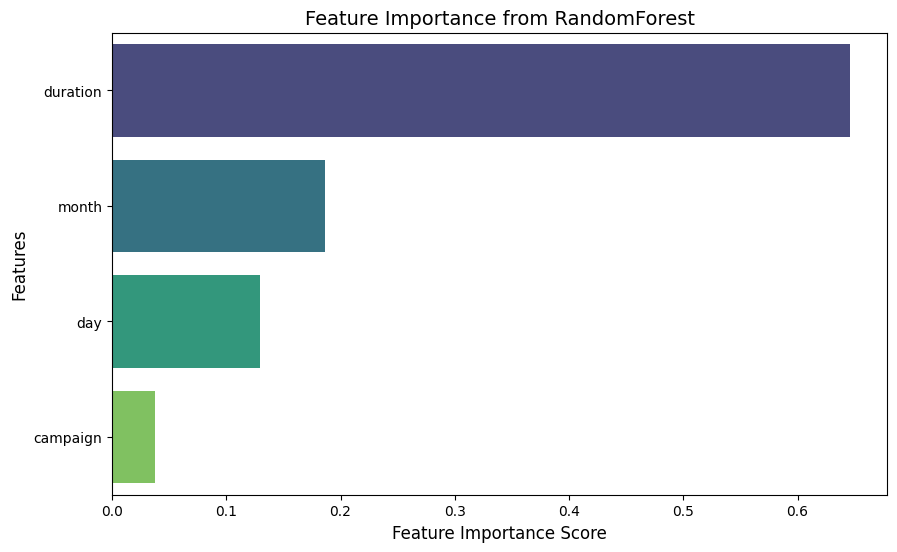

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Train the model on balanced data
#demographic_model.fit(X_train_balanced, y_train_balanced)

# Extract feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train_balanced.columns,
    'Importance': campaign_model.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, hue='Feature', palette="viridis", legend=False)

# Add labels
plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importance from RandomForest", fontsize=14)

plt.show()

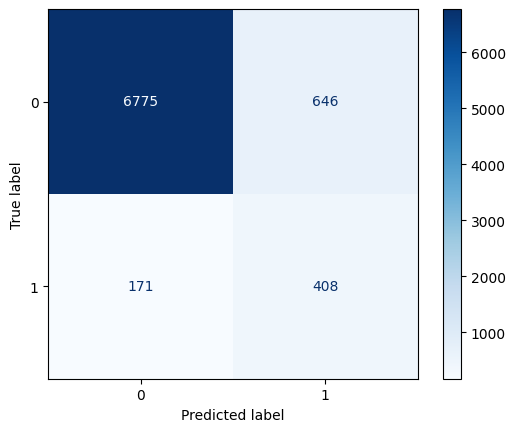

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Train the model on the full training data
#demographic_model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred = campaign_model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix visually
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=campaign_model.classes_)
disp.plot(cmap="Blues")  # You can change the color scheme if you prefer


## Test rf madel with df_campaign_signUpProbability includes probability feature from layer1

In [26]:
# Split the data for training and testing for df_campaign_signUpProbability (data frame layer 1) on Campaign features + layer 1 probability

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, classification_report

X = df_campaign_signUpProbability.drop(columns=['y'])  # Features
y = df_campaign_signUpProbability['y']  # binary: who signed up for term deposits so far

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Check class distribution before SMOTE
print("\nBefore SMOTE:", Counter(y_train))

# Apply SMOTE to balance the training dataset with sythetic data for y
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("\nAfter SMOTE:", Counter(y_train_balanced))

# Train the model without the best parameters (using default or basic parameters)
campaign_model_signUpProbability = RandomForestClassifier(
    n_estimators=100,    # Default value: number of trees
    max_depth=None,      # Default value: no limit on the depth of the tree
    min_samples_split=5, # 5 to guard against overfitting
    min_samples_leaf=2,  # 2 help the model with generalization
    random_state=42      # Ensures reproducibility of results
)

# Perform cross-validation with multiple metrics
scoring_metrics = ['roc_auc', 'recall', 'precision', 'f1', 'accuracy']

# Perform cross-validation
cv_results = cross_validate(campaign_model_signUpProbability, X_train_balanced, y_train_balanced, cv=5, scoring=scoring_metrics, return_train_score=True)

# Print results for each metric
for metric in scoring_metrics:
    print(f"\nCross-validation {metric.upper()}: {cv_results['test_' + metric].mean():.4f} (+/- {cv_results['test_' + metric].std():.4f})")


Before SMOTE: Counter({0: 29683, 1: 2317})

After SMOTE: Counter({0: 29683, 1: 29683})

Cross-validation ROC_AUC: 0.9949 (+/- 0.0006)

Cross-validation RECALL: 0.9906 (+/- 0.0056)

Cross-validation PRECISION: 0.9641 (+/- 0.0017)

Cross-validation F1: 0.9771 (+/- 0.0025)

Cross-validation ACCURACY: 0.9768 (+/- 0.0025)


In [27]:
# Train the model on Layer 2 data
campaign_model_signUpProbability.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5, random_state=42)

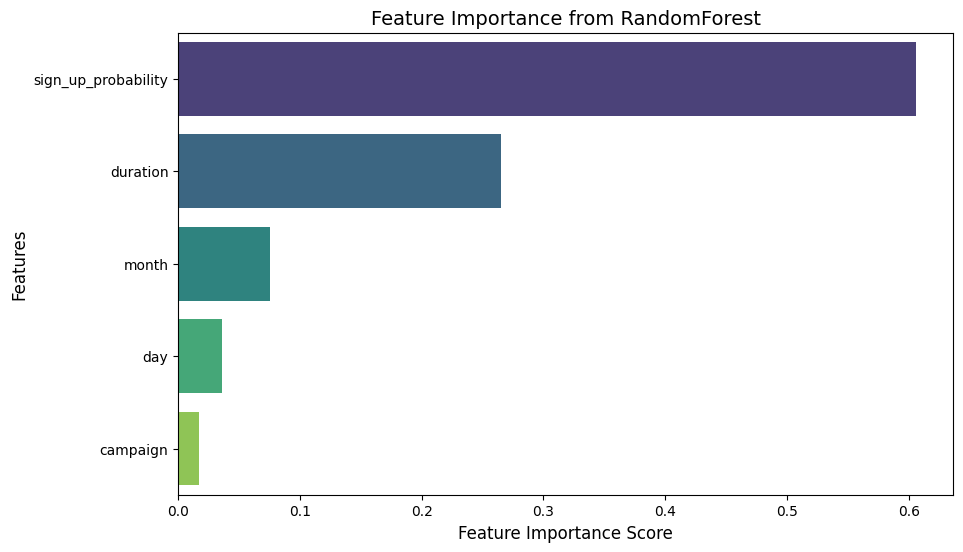

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Extract feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train_balanced.columns,
    'Importance': campaign_model_signUpProbability.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, hue='Feature', palette="viridis", legend=False)

# Add labels
plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importance from RandomForest", fontsize=14)

plt.show()


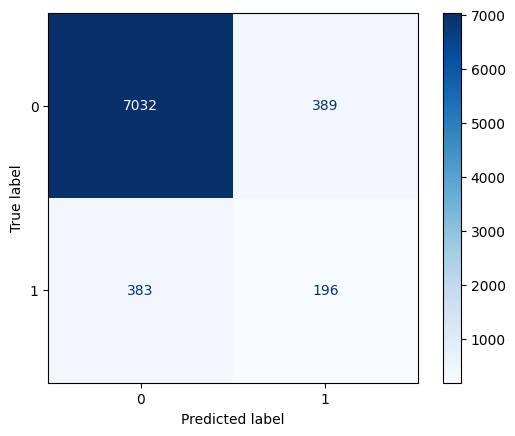

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Train the model on the full training data
#demographic_model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred = campaign_model_signUpProbability.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix visually
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=campaign_model_signUpProbability.classes_)
disp.plot(cmap="Blues")  # You can change the color scheme if you prefer


In [30]:
print(df_90_layer2.columns.tolist())
print(df_90_layer2.index.name)
trained_features = campaign_model_signUpProbability.feature_names_in_
print(trained_features)



['day', 'month', 'duration', 'campaign', 'y', 'customer_id', 'sign_up_probability']
None
['day' 'month' 'duration' 'campaign' 'sign_up_probability']


Leaving in probability feature generated in layer 1 because it leads to a better performing model

In [31]:

# Process df_top50_layer2
#X_top50 = df_top50_layer2.drop(columns=['customer_id', 'y'])
#df_top50_layer2['layer2_sign_up_probability'] = campaign_model_signUpProbability.predict_proba(X_top50)[:, 1]
#print(df_top50_layer2.columns.tolist())

# Here we use the layer 2 model to add the probability that a user will sign up called layer2_sign_up_probability

trained_features = ['day', 'month', 'duration', 'campaign', 'sign_up_probability']

# Process df_90_layer2
X_90 = df_90_layer2.drop(columns=['customer_id', 'y'])
X_90 = X_90[trained_features]  # Reorder to match model input
df_90_layer2['layer2_sign_up_probability'] = campaign_model_signUpProbability.predict_proba(X_90)[:, 1]
print(df_90_layer2.columns.tolist())


# Process df_50_layer2
X_50 = df_50_layer2.drop(columns=['customer_id', 'y'])
X_50 = X_50[trained_features]  # Reorder to match model input
df_50_layer2['layer2_sign_up_probability'] = campaign_model_signUpProbability.predict_proba(X_50)[:, 1]
print(df_50_layer2.columns.tolist())


# Process df_20_layer2
X_20 = df_20_layer2.drop(columns=['customer_id', 'y'])
X_20 = X_20[trained_features]  # Reorder to match model input
df_20_layer2['layer2_sign_up_probability'] = campaign_model_signUpProbability.predict_proba(X_20)[:, 1]
print(df_20_layer2.columns.tolist())



['day', 'month', 'duration', 'campaign', 'y', 'customer_id', 'sign_up_probability', 'layer2_sign_up_probability']
['day', 'month', 'duration', 'campaign', 'y', 'customer_id', 'sign_up_probability', 'layer2_sign_up_probability']
['day', 'month', 'duration', 'campaign', 'y', 'customer_id', 'sign_up_probability', 'layer2_sign_up_probability']


In [32]:
# Sort the list to have the most probably customers to sign up first and least likely last based on Layer 2 probability
#    This will help us identify the customers to target first 

#df_top50_layer2 = df_top50_layer2.sort_values(by='layer2_sign_up_probability', ascending=False)
df_90_layer2 = df_90_layer2.sort_values(by='layer2_sign_up_probability', ascending=False)
df_50_layer2 = df_50_layer2.sort_values(by='layer2_sign_up_probability', ascending=False)
df_20_layer2 = df_20_layer2.sort_values(by='layer2_sign_up_probability', ascending=False)

In [85]:
#print(df_top50_layer2.columns.tolist())
print(df_90_layer2.columns.tolist())
print(df_50_layer2['layer2_sign_up_probability'].describe())
print(df_50_layer2.columns.tolist())
print(df_20_layer2['layer2_sign_up_probability'].describe())
print(df_20_layer2.columns.tolist())
print(df_20_layer2['layer2_sign_up_probability'].describe())

['day', 'month', 'duration', 'campaign', 'y', 'customer_id', 'sign_up_probability', 'layer2_sign_up_probability', 'age', 'education', 'default', 'balance', 'housing', 'loan', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'contact_telephone', 'contact_unknown', 'marital_married', 'marital_single', 'probability_bin']
count    3200.000000
mean        0.215108
std         0.262764
min         0.000000
25%         0.009940
50%         0.084184
75%         0.366061
max         1.000000
Name: layer2_sign_up_probability, dtype: float64
['day', 'month', 'duration', 'campaign', 'y', 'customer_id', 'sign_up_probability', 'layer2_sign_up_probability', 'age', 'education', 'default', 'balance', 'housing', 'loan', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job

In [34]:
# Now that we have the final probabilities based on campaign data for the list of best customers from the 
# demographic data, we can merge the two datasets to get the final list of customers to target
#
#     Merge back in all the features that were dropped from the demographic data to get a full picture of
#     the customers we are targeting
#
# Drop campaign-related columns from df to avoid duplication

df_extra_features = df.drop(columns=['day', 'month', 'duration', 'campaign', 'y'])

# Merge back the missing features using 'customer_id' as the key
#df_top50_layer2 = df_top50_layer2.merge(df_extra_features, on='customer_id', how='left')
df_90_layer2 = df_90_layer2.merge(df_extra_features, on='customer_id', how='left')
df_50_layer2 = df_50_layer2.merge(df_extra_features, on='customer_id', how='left')
df_20_layer2 = df_20_layer2.merge(df_extra_features, on='customer_id', how='left')

# Check the updated columns
#print(df_top50_layer2.columns.tolist())
print(df_90_layer2.columns.tolist())
print(df_50_layer2.columns.tolist())
print(df_20_layer2.columns.tolist())


['day', 'month', 'duration', 'campaign', 'y', 'customer_id', 'sign_up_probability', 'layer2_sign_up_probability', 'age', 'education', 'default', 'balance', 'housing', 'loan', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'contact_telephone', 'contact_unknown', 'marital_married', 'marital_single']
['day', 'month', 'duration', 'campaign', 'y', 'customer_id', 'sign_up_probability', 'layer2_sign_up_probability', 'age', 'education', 'default', 'balance', 'housing', 'loan', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'contact_telephone', 'contact_unknown', 'marital_married', 'marital_single']
['day', 'month', 'duration', 'campaign', 'y', 'customer_id', 'sign_up_probability', 'layer2_sign_up_probability'

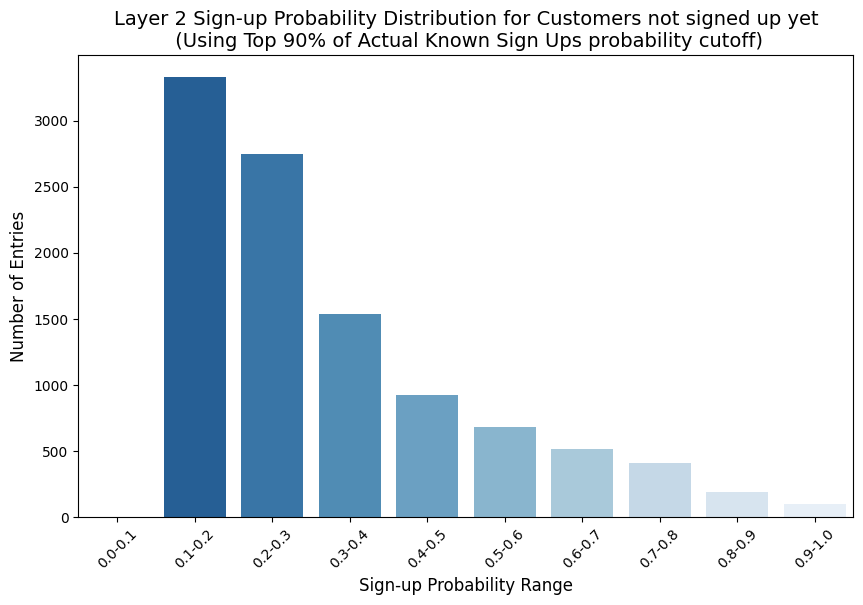

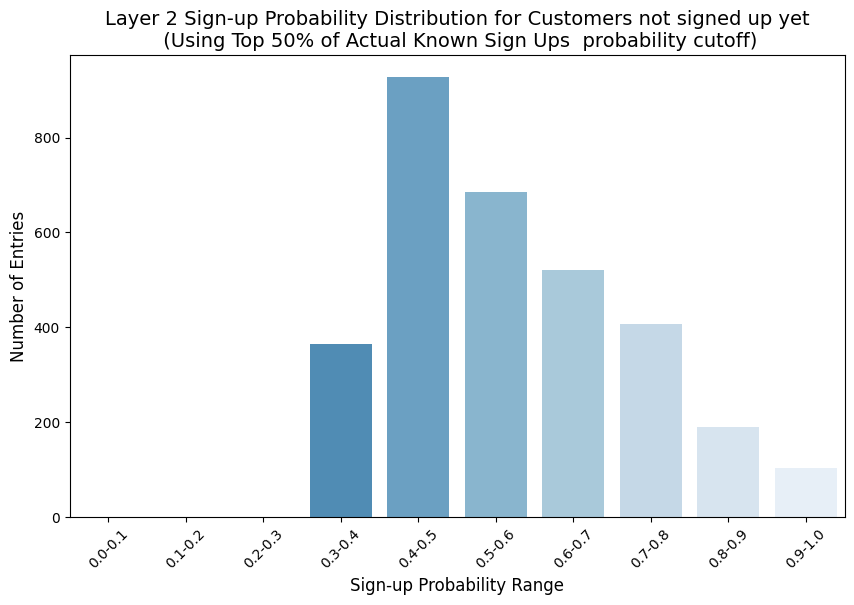

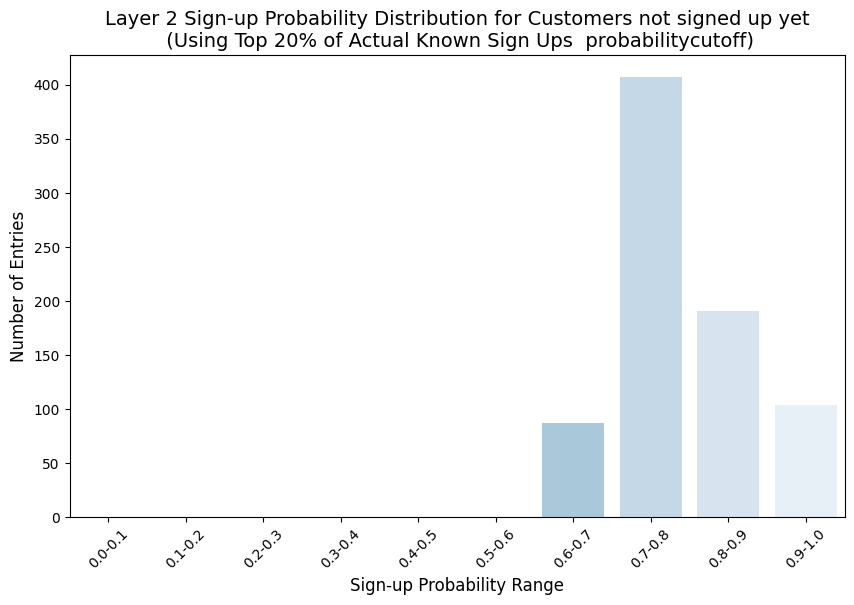

In [36]:
# plot distribution of probabilities in our sorted list of likely customers to sign up

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot distribution of sign-up probabilities
def plot_probability_distribution(df, title):
    plt.figure(figsize=(10, 6))

    # Define bins (0 to 1 in steps of 0.1)
    bins = np.arange(0, 1.1, 0.1)
    labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]

    # Categorize data into bins
    df['probability_bin'] = pd.cut(df['sign_up_probability'], bins=bins, labels=labels, include_lowest=True)

    # Count occurrences in each bin
    bin_counts = df['probability_bin'].value_counts().sort_index()

    # Plot the bar chart
    sns.barplot(
        x=bin_counts.index, 
        y=bin_counts.values, 
        hue=bin_counts.index,  # Assign x to hue
        palette="Blues_r", 
        legend=False  # Disable legend since hue is just for color
    )

    # Add labels and title
    plt.xlabel("Sign-up Probability Range", fontsize=12)
    plt.ylabel("Number of Entries", fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45)

    plt.show()

# Plot distributions for different dataframes
#plot_probability_distribution(df_top50_layer2, "Layer 2 Sign-up Probability Distribution for Customers not signed up yet\n (Using Top 50% All Customers probability cutoff)")
plot_probability_distribution(df_90_layer2, "Layer 2 Sign-up Probability Distribution for Customers not signed up yet\n (Using Top 90% of Actual Known Sign Ups probability cutoff)")
plot_probability_distribution(df_50_layer2, "Layer 2 Sign-up Probability Distribution for Customers not signed up yet\n (Using Top 50% of Actual Known Sign Ups  probability cutoff)")
plot_probability_distribution(df_20_layer2, "Layer 2 Sign-up Probability Distribution for Customers not signed up yet\n (Using Top 20% of Actual Known Sign Ups  probabilitycutoff)")


In [37]:
# Create dataframes with original columns before one hot ordinal and binary changes to original dataframe

import pandas as pd

# Function to revert encoded dataframes
def revert_encoding(df):
    df_reverted = df.copy()  # Create a copy to avoid modifying the original

    # Reverse Binary Encoding
    binary_columns_reverse = {
        'default': {0: 'no', 1: 'yes'},
        'housing': {0: 'no', 1: 'yes'},
        'loan': {0: 'no', 1: 'yes'},
        'y': {0: 'no', 1: 'yes'}
    }
    for column, mapping in binary_columns_reverse.items():
        if column in df_reverted.columns:
            df_reverted[column] = df_reverted[column].map(mapping)

    # Reverse One-Hot Encoding
    if any(col.startswith('job_') for col in df_reverted.columns):
        df_reverted['job'] = df_reverted[[col for col in df_reverted.columns if 'job_' in col]].idxmax(axis=1).str.replace('job_', '')
        df_reverted.drop(columns=[col for col in df_reverted.columns if 'job_' in col], inplace=True)

    if any(col.startswith('contact_') for col in df_reverted.columns):
        df_reverted['contact'] = df_reverted[[col for col in df_reverted.columns if 'contact_' in col]].idxmax(axis=1).str.replace('contact_', '')
        df_reverted.drop(columns=[col for col in df_reverted.columns if 'contact_' in col], inplace=True)

    if any(col.startswith('marital_') for col in df_reverted.columns):
        df_reverted['marital'] = df_reverted[[col for col in df_reverted.columns if 'marital_' in col]].idxmax(axis=1).str.replace('marital_', '')
        df_reverted.drop(columns=[col for col in df_reverted.columns if 'marital_' in col], inplace=True)

    # Reverse Ordinal Encoding
    education_mapping_reverse = {0: 'unknown', 1: 'primary', 2: 'secondary', 3: 'tertiary'}
    month_mapping_reverse = {1: 'jan', 2: 'feb', 3: 'mar', 4: 'apr', 5: 'may', 6: 'jun',
                             7: 'jul', 8: 'aug', 9: 'sep', 10: 'oct', 11: 'nov', 12: 'dec'}

    if 'education' in df_reverted.columns:
        df_reverted['education'] = df_reverted['education'].map(education_mapping_reverse)

    if 'month' in df_reverted.columns:
        df_reverted['month'] = df_reverted['month'].map(month_mapping_reverse)

    return df_reverted

# List of encoded dataframes
df_list = {
    'df_top50_layer2': df_top50_layer2,
    'df_90_layer2': df_90_layer2,
    'df_50_layer2': df_50_layer2,
    'df_20_layer2': df_20_layer2
}

# Create reverted versions with "_original" appended
for name, df in df_list.items():
    globals()[f"{name}_allColumns"] = revert_encoding(df)

# Check results
print(df_top50_layer2_allColumns.head())
print()
print(df_90_layer2_allColumns.head())
print()
print(df_50_layer2_allColumns.head())
print()
print(df_20_layer2_allColumns.head())




   day month  duration  campaign   y  customer_id  sign_up_probability
0    5   may       380         1  no            7             0.094016
1    5   may        55         1  no            9             0.082109
2    5   may       222         1  no           10             0.347185
3    5   may       137         1  no           11             0.088222
4    5   may      1666         1  no           37             0.117391

   day month  duration  campaign   y  customer_id  sign_up_probability  \
0   14   may       532         1  no        37632             0.411160   
1   11   may       772         2  no        36440             0.343900   
2   15   jul      1083         2  no        14684             0.354118   
3   16   jul      1056         2  no        14965             0.856289   
4   15   may      1223         3  no        38679             0.528173   

   layer2_sign_up_probability  age  education default  balance housing loan  \
0                         1.0   32  secondary    


📊 Visualizing Data for: Using Top 90% of Actual Known Sign Ups probability cutoff



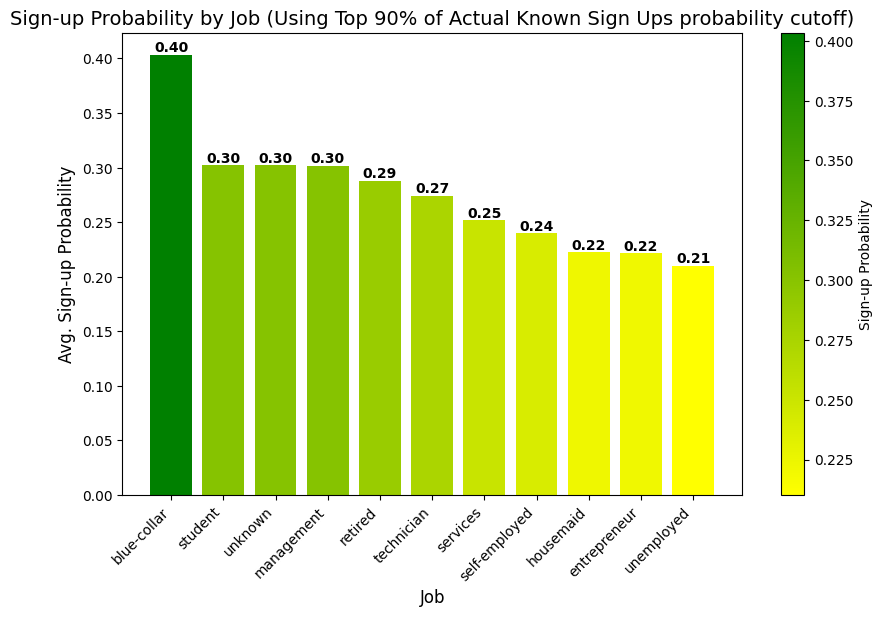

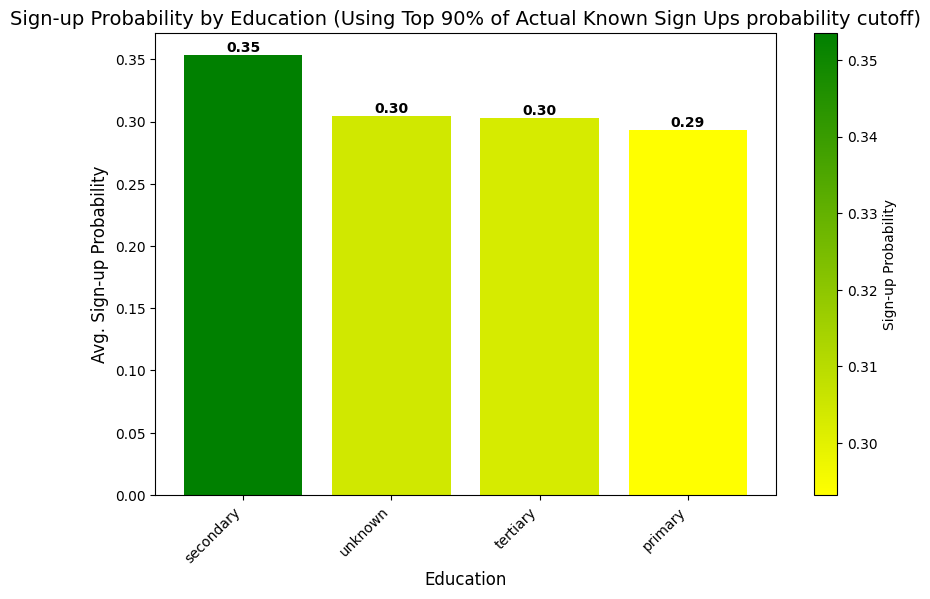

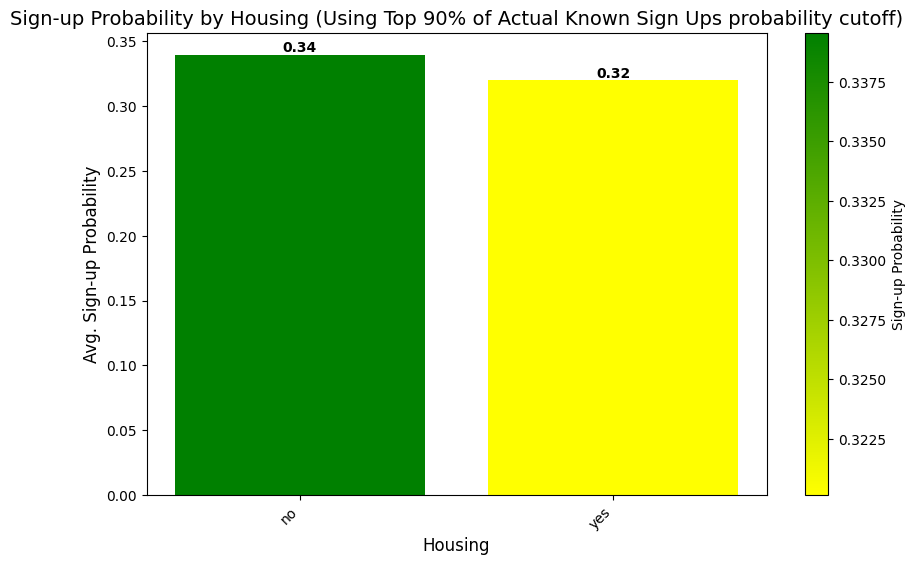

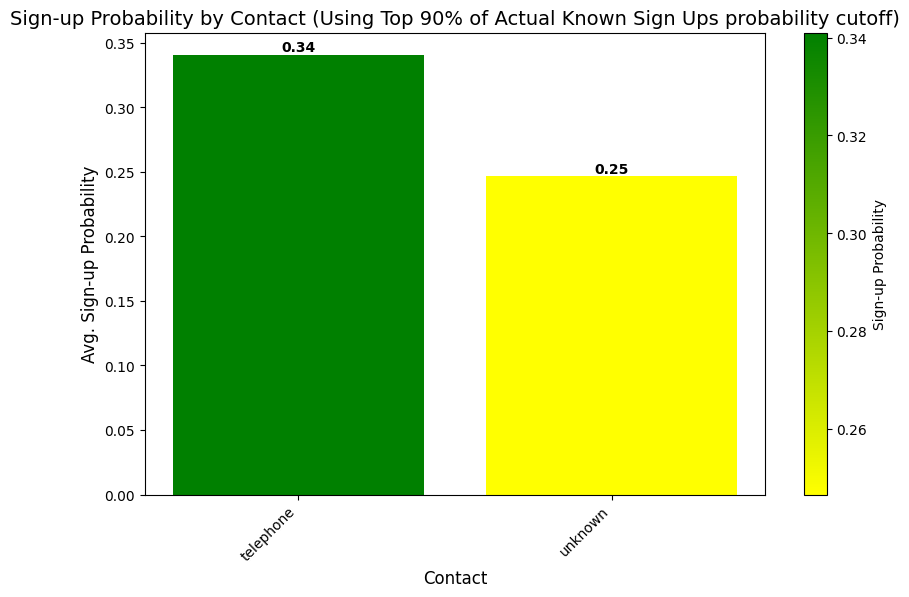

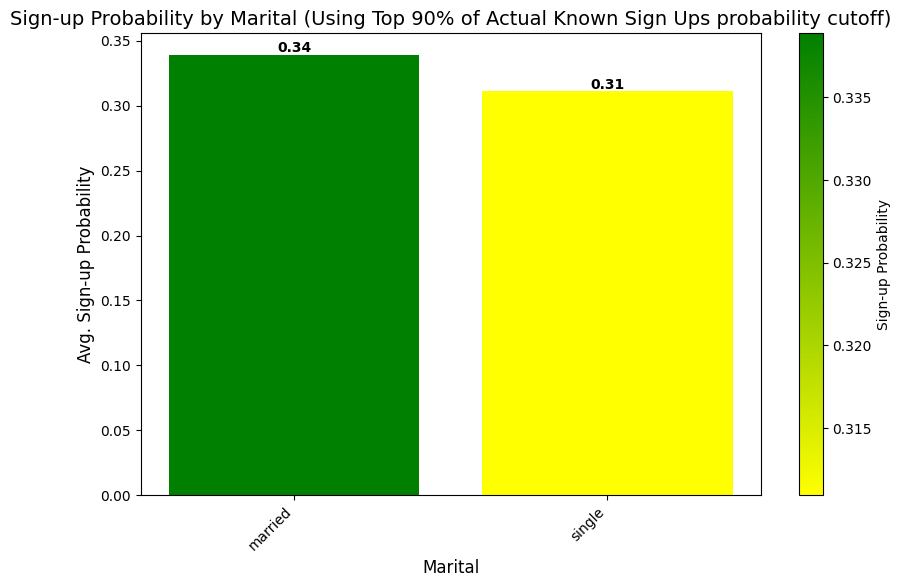


📊 Visualizing Data for: Using Top 50% of Actual Known Sign Ups probability cutoff



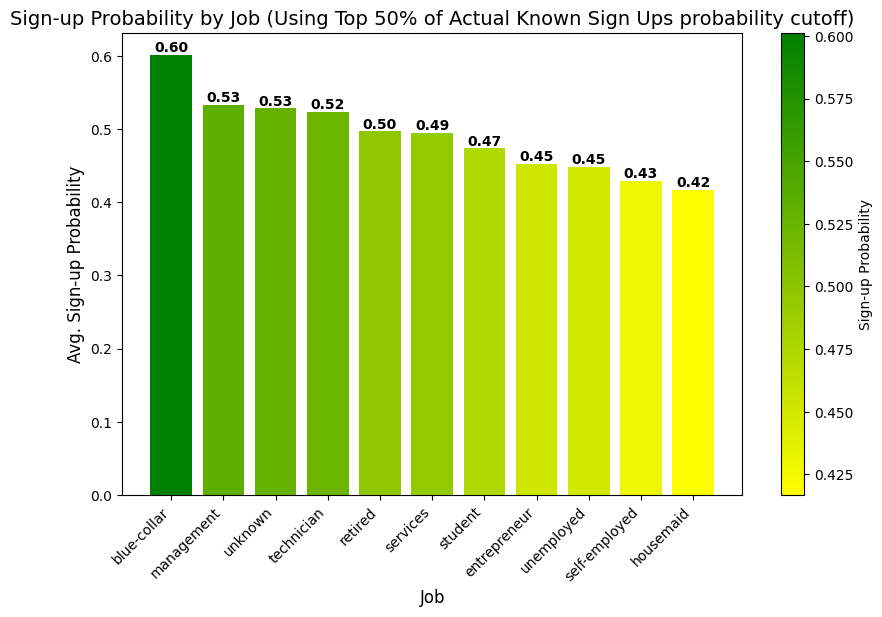

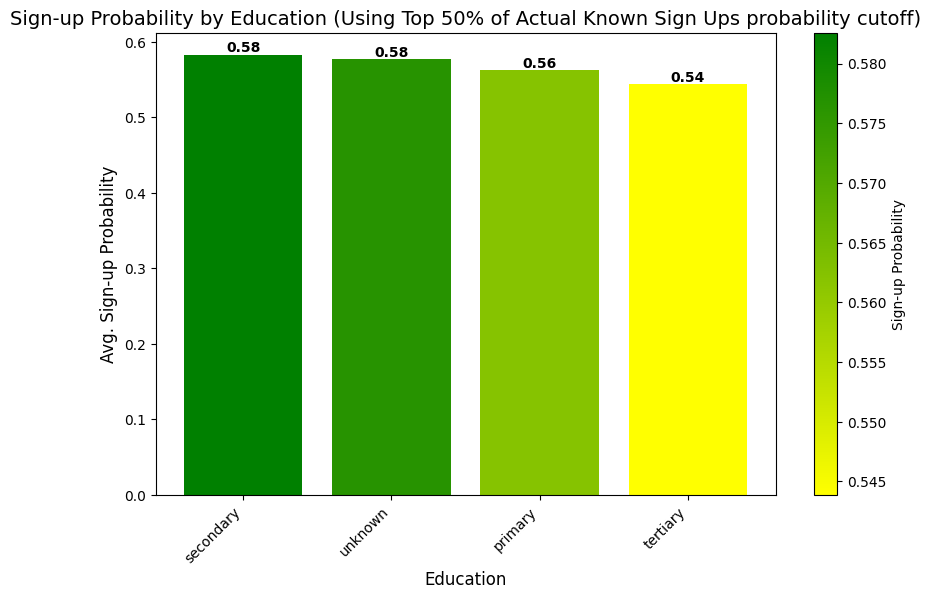

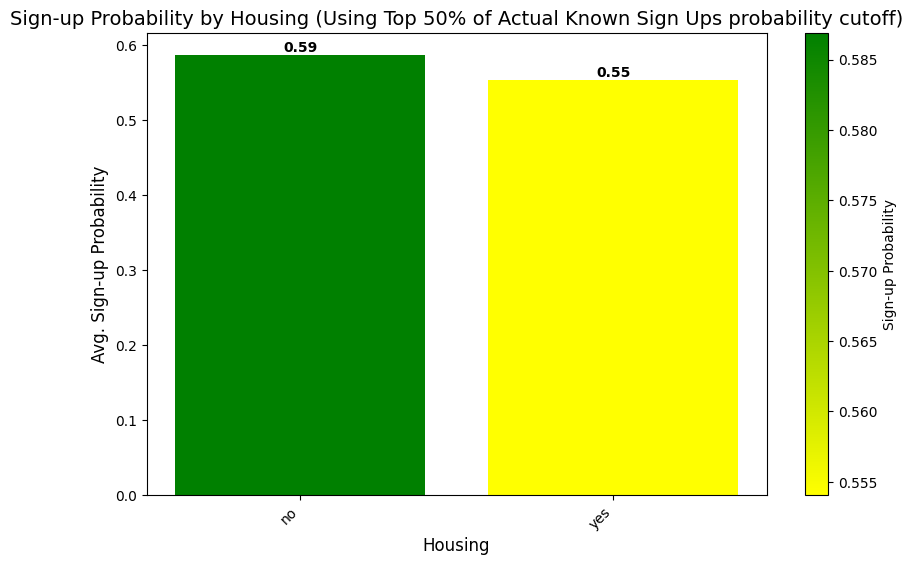

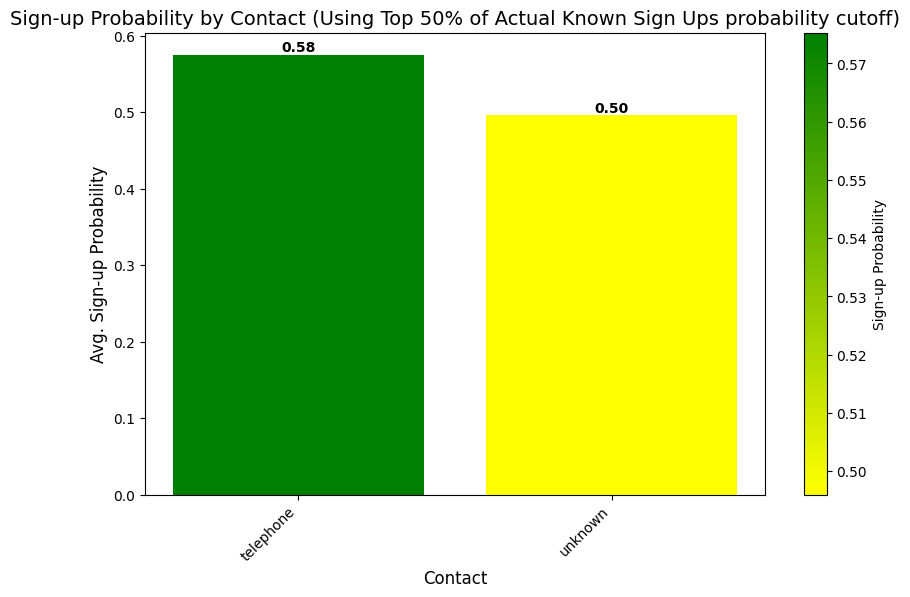

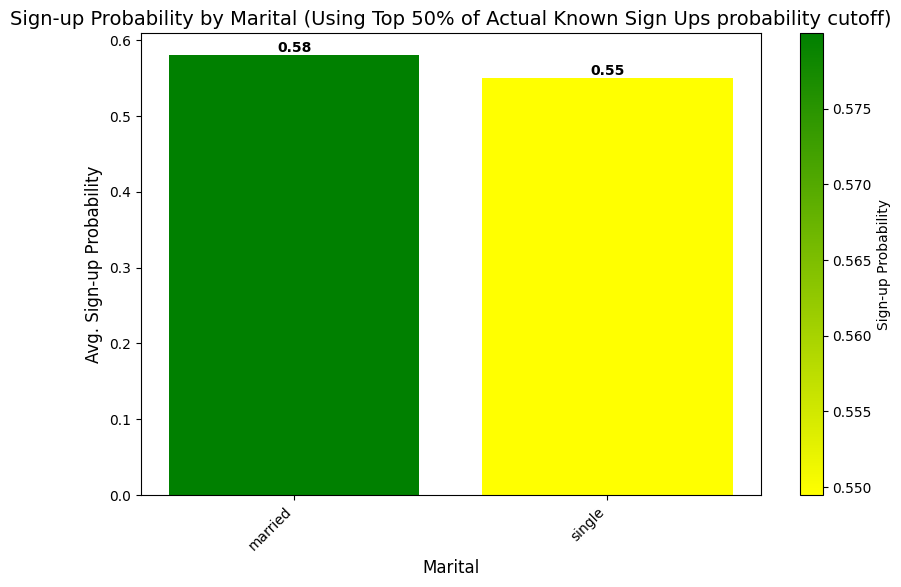


📊 Visualizing Data for: Using Top 20% of Actual Known Sign Ups probability cutoff



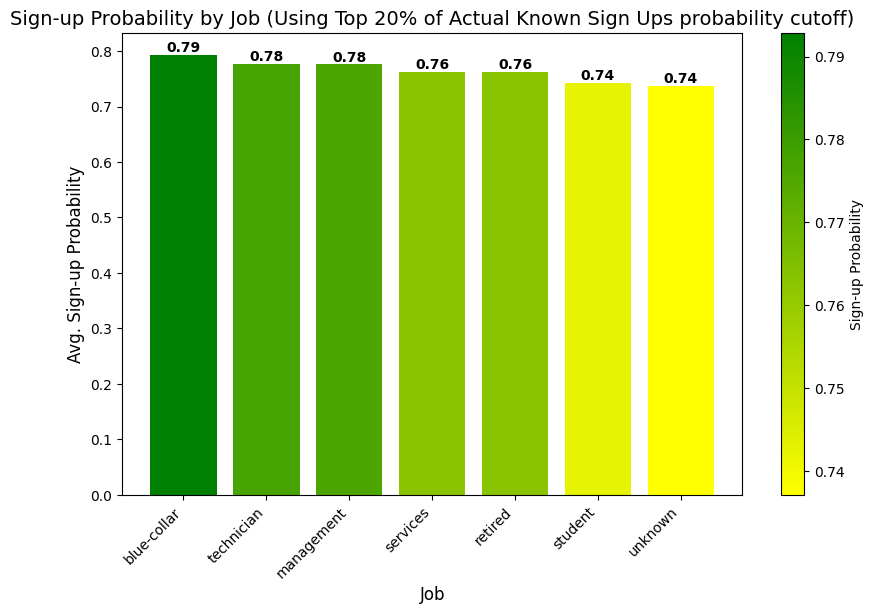

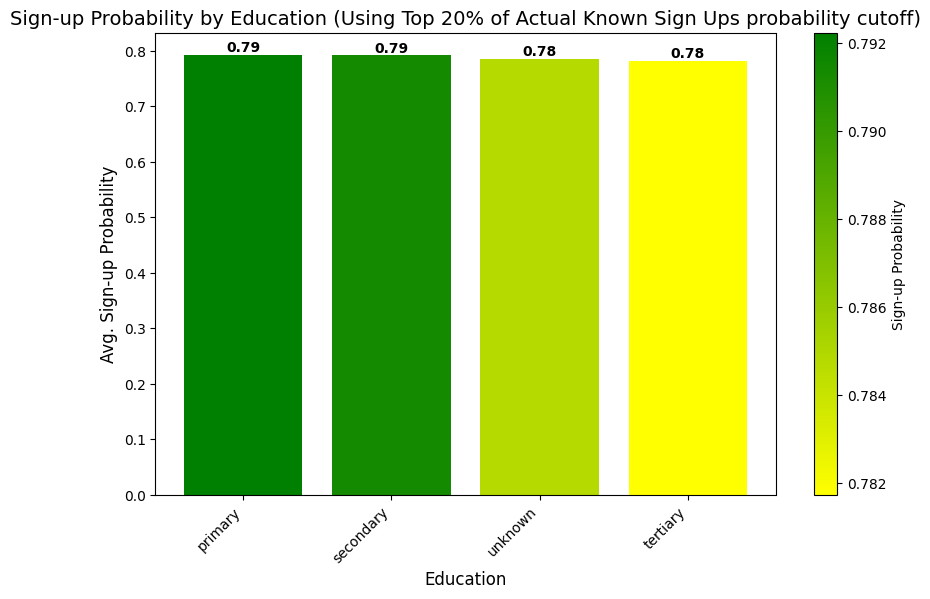

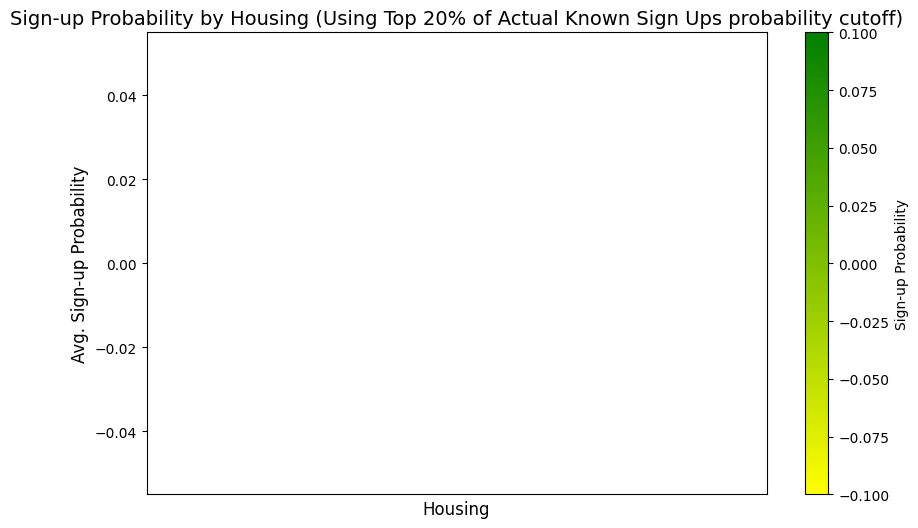

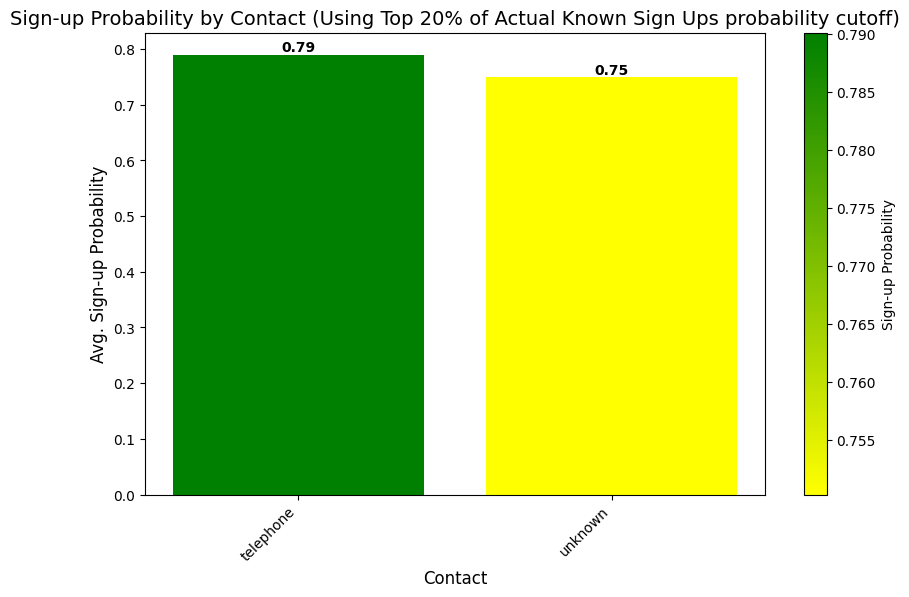

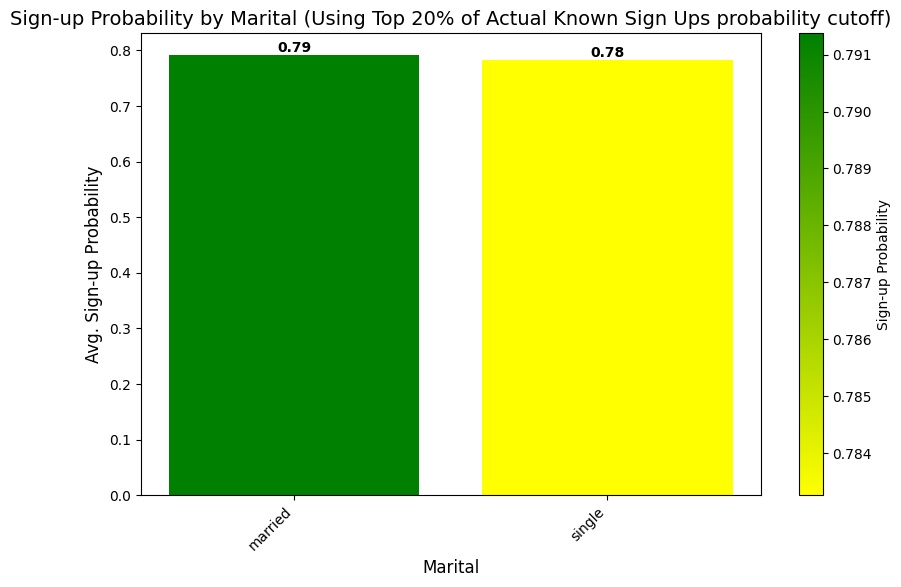

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define a colormap from yellow (low) to green (high)
custom_cmap = LinearSegmentedColormap.from_list("yellow_to_green", ["yellow", "green"])

# Function to create colored bar charts with labels
def plot_colored_bar(df, x_col, title):
    fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axis

    # Compute average sign-up probability per category
    avg_prob = df.groupby(x_col)['sign_up_probability'].mean().reset_index()

    # Sort values for better visualization
    avg_prob = avg_prob.sort_values(by='sign_up_probability', ascending=False)

    # Normalize sign-up probabilities for colormap
    norm = plt.Normalize(vmin=avg_prob['sign_up_probability'].min(),
                         vmax=avg_prob['sign_up_probability'].max())

    # Use the custom colormap (Yellow to Green)
    colors = [custom_cmap(norm(prob)) for prob in avg_prob['sign_up_probability']]

    # Plot bar chart
    bars = ax.bar(avg_prob[x_col], avg_prob['sign_up_probability'], color=colors)

    # Add labels above bars
    for bar, prob in zip(bars, avg_prob['sign_up_probability']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f"{prob:.2f}", 
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

    # Add labels
    ax.set_xlabel(x_col.capitalize(), fontsize=12)
    ax.set_ylabel("Avg. Sign-up Probability", fontsize=12)
    ax.set_title(title, fontsize=14)

    # Rotate x-axis labels if needed
    ax.set_xticks(range(len(avg_prob[x_col])))  # Set tick positions
    ax.set_xticklabels(avg_prob[x_col], rotation=45, ha="right")  # Now safely set labels

    #ax.set_xticklabels(avg_prob[x_col], rotation=45, ha="right")

    # Create color bar with a ScalarMappable
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])  # Dummy array for colorbar reference
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Sign-up Probability")

    plt.show()


# Define the dataframes and corresponding titles
dataframes = {
    "Using Top 90% of Actual Known Sign Ups probability cutoff": df_90_layer2_allColumns,
    "Using Top 50% of Actual Known Sign Ups probability cutoff": df_50_layer2_allColumns,
    "Using Top 20% of Actual Known Sign Ups probability cutoff": df_20_layer2_allColumns
}

# List of categorical columns to visualize
categories = ['job', 'education', 'housing', 'contact', 'marital']

# Iterate over each dataframe and plot
for df_name, df in dataframes.items():
    # Print a section header before plotting for each dataset
    print("\n" + "="*100)  # Creates a visual separator
    print(f"📊 Visualizing Data for: {df_name}")
    print("="*100 + "\n")
    
    for category in categories:
        plot_colored_bar(df, category, f"Sign-up Probability by {category.capitalize()} ({df_name})")



📊 Visualizing Data for: Using Top 90% of Actual Known Sign Ups probability cutoff



C:\Users\cltur\AppData\Local\Temp\ipykernel_13600\4091729810.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_prob = df.groupby('age_bin')['sign_up_probability'].mean().reset_index()
C:\Users\cltur\AppData\Local\Temp\ipykernel_13600\4091729810.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(avg_prob['age_bin'], rotation=45, ha="right")


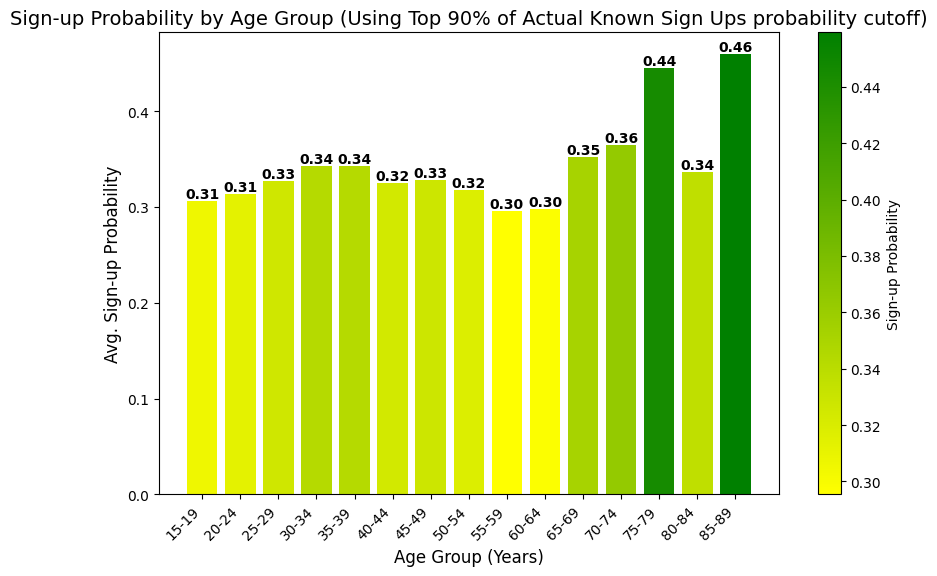


📊 Visualizing Data for: Using Top 50% of Actual Known Sign Ups probability cutoff



C:\Users\cltur\AppData\Local\Temp\ipykernel_13600\4091729810.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_prob = df.groupby('age_bin')['sign_up_probability'].mean().reset_index()
C:\Users\cltur\AppData\Local\Temp\ipykernel_13600\4091729810.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(avg_prob['age_bin'], rotation=45, ha="right")


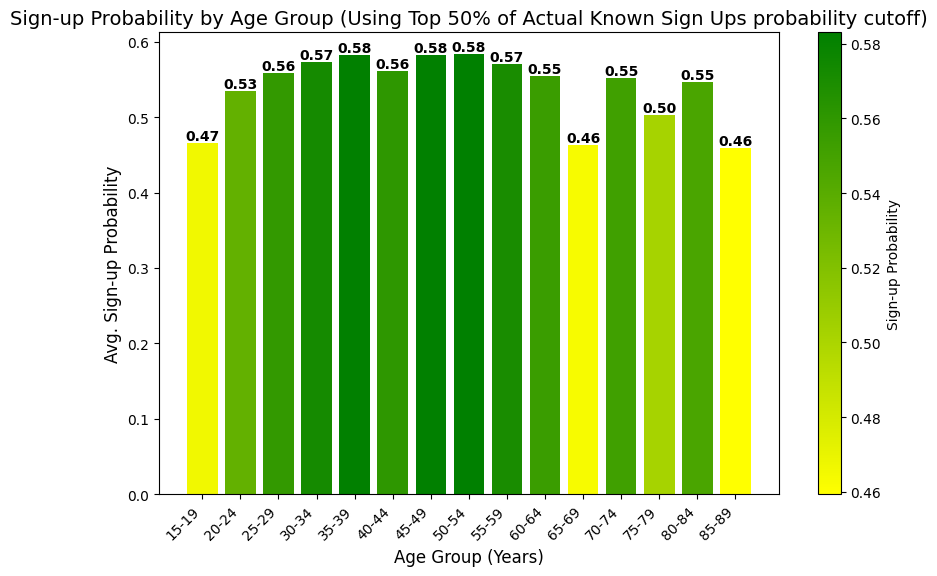


📊 Visualizing Data for: Using Top 20% of Actual Known Sign Ups probability cutoff



C:\Users\cltur\AppData\Local\Temp\ipykernel_13600\4091729810.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_prob = df.groupby('age_bin')['sign_up_probability'].mean().reset_index()
C:\Users\cltur\AppData\Local\Temp\ipykernel_13600\4091729810.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(avg_prob['age_bin'], rotation=45, ha="right")
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


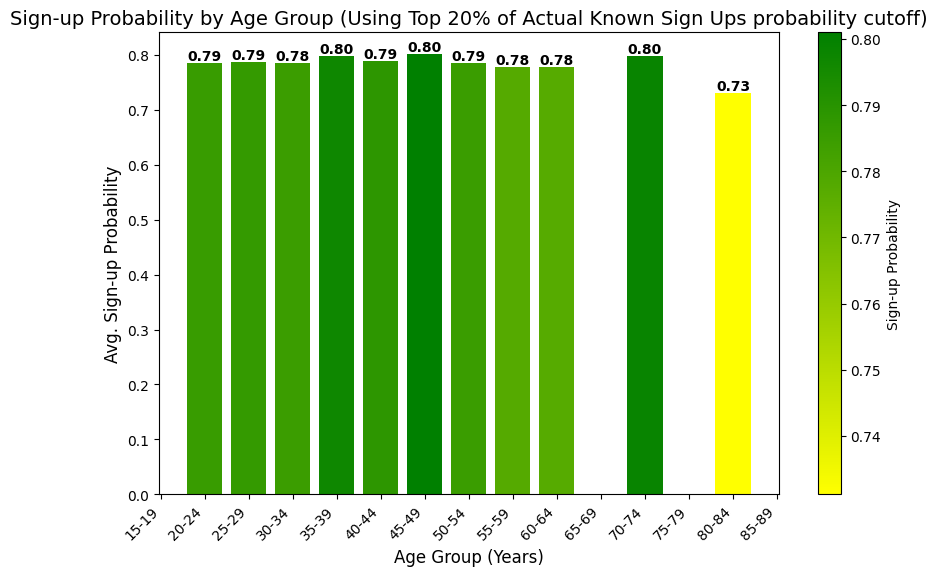

In [184]:
# Create plots for age feature in the three sorted lists

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define a colormap from yellow (low) to green (high)
custom_cmap = LinearSegmentedColormap.from_list("yellow_to_green", ["yellow", "green"])

# Function to create age bins in 5-year intervals
def create_age_bins(df, age_col='age'):
    bin_edges = list(range(15, 95, 5))  # Bins from 15 to 90, step 5
    bin_labels = [f"{start}-{start+4}" for start in bin_edges[:-1]]  # Labels like '15-19', '20-24', etc.
    df['age_bin'] = pd.cut(df[age_col], bins=bin_edges, labels=bin_labels, right=False)
    return df, bin_labels

# Function to create colored bar charts for age bins
def plot_colored_bar(df, title, bin_labels):
    fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axis

    # Compute average sign-up probability per age bin
    avg_prob = df.groupby('age_bin')['sign_up_probability'].mean().reset_index()

    # Sort values for better visualization
    #avg_prob = avg_prob.sort_values(by='sign_up_probability', ascending=False)

    # Ensure age bins are sorted correctly
    avg_prob['age_bin'] = pd.Categorical(avg_prob['age_bin'], categories=bin_labels, ordered=True)
    avg_prob = avg_prob.sort_values(by='age_bin')  # Sort by age order instead of probability

    # Normalize sign-up probabilities for colormap
    norm = plt.Normalize(vmin=avg_prob['sign_up_probability'].min(),
                         vmax=avg_prob['sign_up_probability'].max())

    # Use the custom colormap (Yellow to Green)
    colors = [custom_cmap(norm(prob)) for prob in avg_prob['sign_up_probability']]

    # Plot bar chart
    bars = ax.bar(avg_prob['age_bin'], avg_prob['sign_up_probability'], color=colors)

    # Add labels above bars
    for bar, prob in zip(bars, avg_prob['sign_up_probability']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f"{prob:.2f}", 
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

    # Add labels
    ax.set_xlabel("Age Group (Years)", fontsize=12)
    ax.set_ylabel("Avg. Sign-up Probability", fontsize=12)
    ax.set_title(title, fontsize=14)

    # Rotate x-axis labels for better readability
    ax.set_xticklabels(avg_prob['age_bin'], rotation=45, ha="right")

    # Create color bar with a ScalarMappable
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])  # Dummy array for colorbar reference
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Sign-up Probability")

    plt.show()


# Define the dataframes and corresponding titles
dataframes = {
    "Using Top 90% of Actual Known Sign Ups probability cutoff": df_90_layer2_allColumns,
    "Using Top 50% of Actual Known Sign Ups probability cutoff": df_50_layer2_allColumns,
    "Using Top 20% of Actual Known Sign Ups probability cutoff": df_20_layer2_allColumns
}


# Process and plot data for 'age' only, using bins
for df_name, df in dataframes.items():
    print("\n" + "="*100)  # Creates a visual separator
    print(f"📊 Visualizing Data for: {df_name}")
    print("="*100 + "\n")

    df, bin_labels = create_age_bins(df)  # Apply age binning
    plot_colored_bar(df, f"Sign-up Probability by Age Group ({df_name})", bin_labels)



📊 Visualizing Data for: Using Top 90% of Actual Known Sign Ups probability cutoff



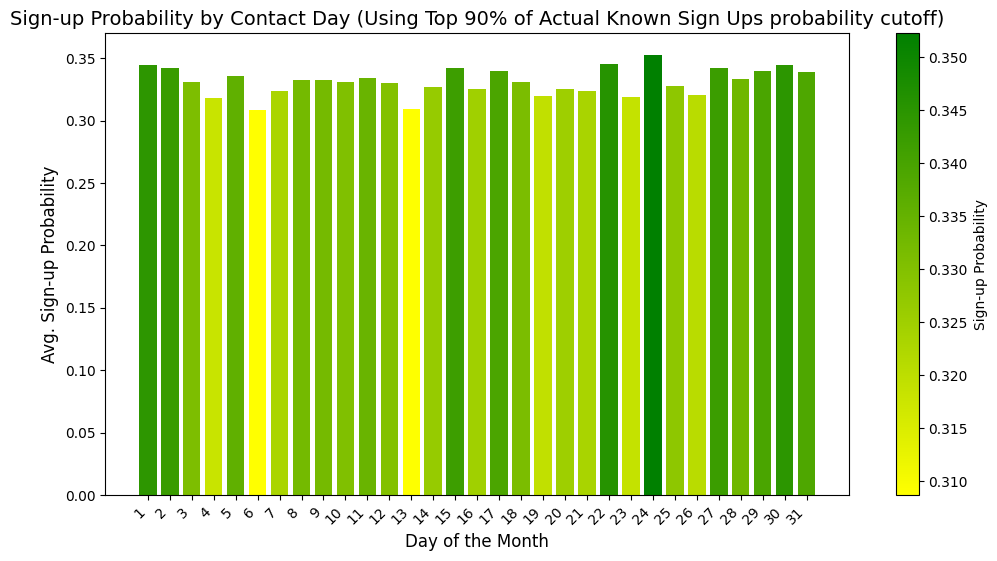


📊 Visualizing Data for: Using Top 50% of Actual Known Sign Ups probability cutoff



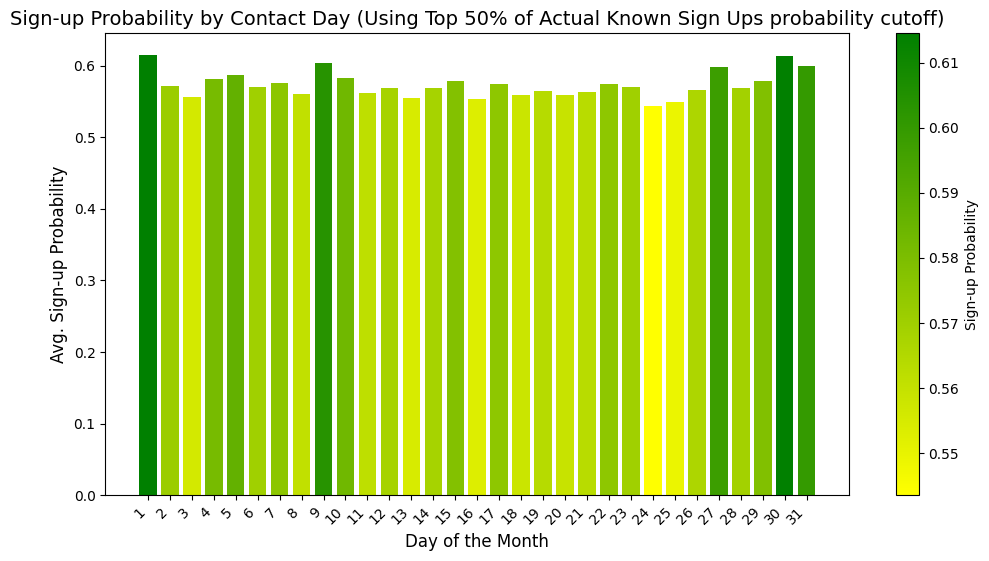


📊 Visualizing Data for: Using Top 20% of Actual Known Sign Ups probability cutoff



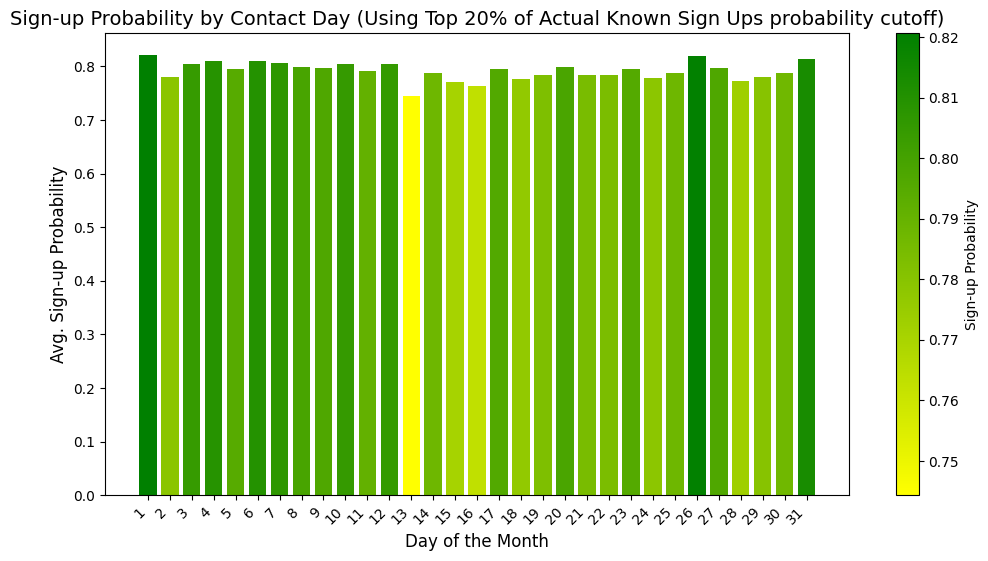

In [183]:
# code to visulize day feature for each of the three sorted lists

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define a colormap from yellow (low) to green (high)
custom_cmap = LinearSegmentedColormap.from_list("yellow_to_green", ["yellow", "green"])

def plot_colored_bar_day(df, title):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Compute average sign-up probability per day
    avg_prob = df.groupby('day')['sign_up_probability'].mean().reset_index()

    # Ensure 'day' is numeric and sorted
    avg_prob['day'] = avg_prob['day'].astype(int)
    avg_prob = avg_prob.sort_values(by='day')

    # Normalize for color mapping
    norm = plt.Normalize(vmin=avg_prob['sign_up_probability'].min(),
                         vmax=avg_prob['sign_up_probability'].max())

    # Create bar positions (ensuring alignment)
    x_positions = np.arange(len(avg_prob))  # Sequential integer positions

    # Use the custom colormap
    colors = [custom_cmap(norm(prob)) for prob in avg_prob['sign_up_probability']]

    # Plot bar chart with correct alignment
    bars = ax.bar(x_positions, avg_prob['sign_up_probability'], color=colors, align='center')



    # Set correct tick positions & labels
    ax.set_xticks(x_positions)  # Aligns ticks with bars
    ax.set_xticklabels(avg_prob['day'], rotation=45, ha="right")  # Uses actual days

    # Labels and title
    ax.set_xlabel("Day of the Month", fontsize=12)
    ax.set_ylabel("Avg. Sign-up Probability", fontsize=12)
    ax.set_title(title, fontsize=14)

    # Color bar
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Sign-up Probability")

    plt.show()


# Define the dataframes and corresponding titles
dataframes = {
    "Using Top 90% of Actual Known Sign Ups probability cutoff": df_90_layer2_allColumns,
    "Using Top 50% of Actual Known Sign Ups probability cutoff": df_50_layer2_allColumns,
    "Using Top 20% of Actual Known Sign Ups probability cutoff": df_20_layer2_allColumns
}


# Process and plot data for 'day' feature
for df_name, df in dataframes.items():
    print("\n" + "="*100)  # Creates a visual separator
    print(f"📊 Visualizing Data for: {df_name}")
    print("="*100 + "\n")

    plot_colored_bar_day(df, f"Sign-up Probability by Contact Day ({df_name})")



📊 Visualizing Data for: Using Top 90% of Actual Known Sign Ups probability cutoff



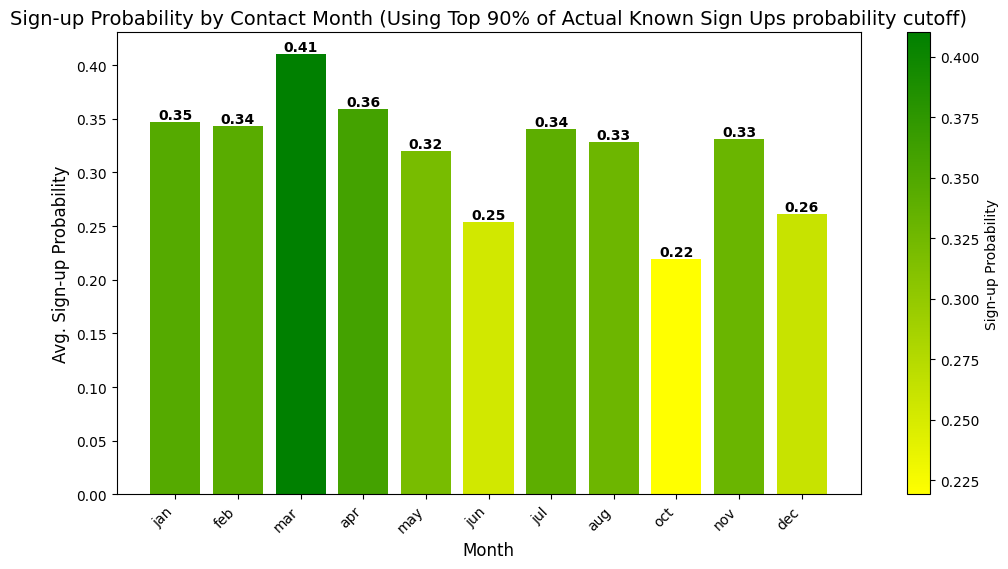


📊 Visualizing Data for: Using Top 50% of Actual Known Sign Ups probability cutoff



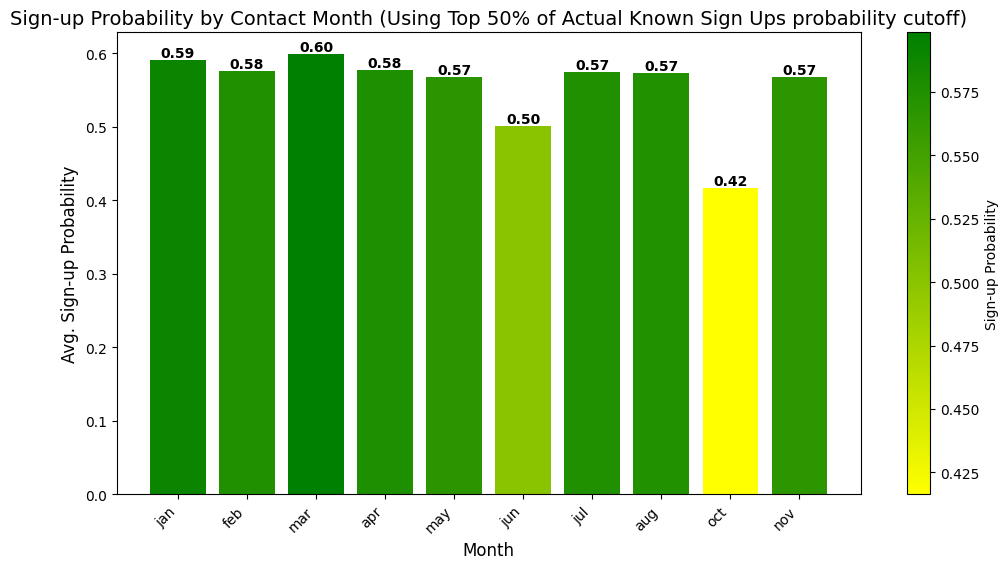


📊 Visualizing Data for: Using Top 20% of Actual Known Sign Ups probability cutoff



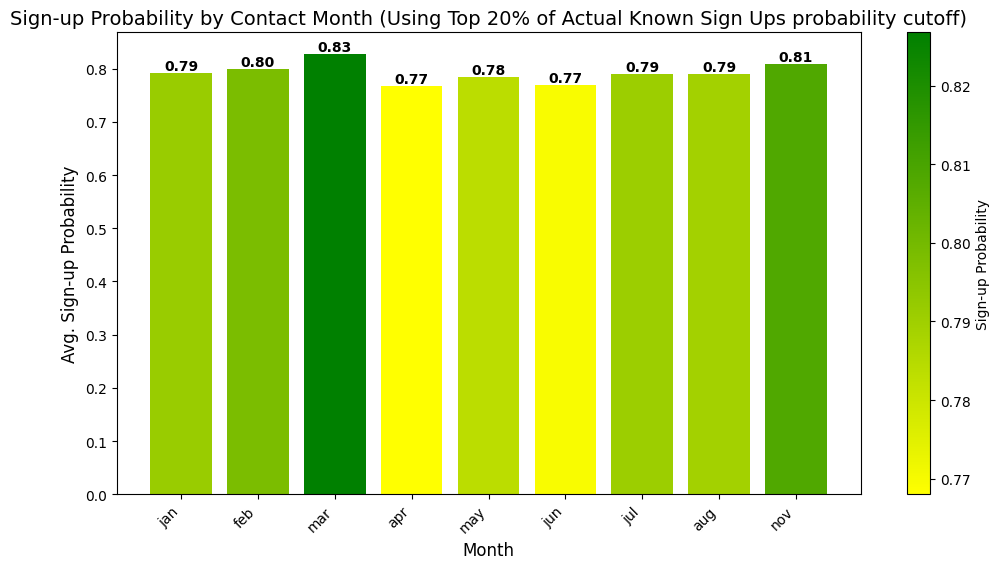

In [182]:
# code to visulize month feature for each of the three sorted lists

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define a colormap from yellow (low) to green (high)
custom_cmap = LinearSegmentedColormap.from_list("yellow_to_green", ["yellow", "green"])

def plot_colored_bar_month(df, title):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Define mapping of months to numbers for sorting
    month_order = {
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
        'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    }

    # Replace categorical month names with numbers
    df['month_num'] = df['month'].map(month_order)

    # Compute average sign-up probability per month
    avg_prob = df.groupby('month')['sign_up_probability'].mean().reset_index()

    # Map months to numbers and sort
    avg_prob['month_num'] = avg_prob['month'].map(month_order)
    avg_prob = avg_prob.sort_values(by='month_num')

    # Normalize probabilities for colormap
    norm = plt.Normalize(vmin=avg_prob['sign_up_probability'].min(),
                         vmax=avg_prob['sign_up_probability'].max())

    # Create x-axis positions
    x_positions = np.arange(len(avg_prob))  # Sequential positions for bars

    # Use custom colormap
    colors = [custom_cmap(norm(prob)) for prob in avg_prob['sign_up_probability']]

    # Plot bar chart
    bars = ax.bar(x_positions, avg_prob['sign_up_probability'], color=colors, align='center')

    # Add labels above bars
    for bar, prob in zip(bars, avg_prob['sign_up_probability']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f"{prob:.2f}", 
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

    # Set x-ticks to month names
    ax.set_xticks(x_positions)
    ax.set_xticklabels(avg_prob['month'], rotation=45, ha="right")  # Display month names

    # Labels and title
    ax.set_xlabel("Month", fontsize=12)
    ax.set_ylabel("Avg. Sign-up Probability", fontsize=12)
    ax.set_title(title, fontsize=14)

    # Color bar
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Sign-up Probability")

    plt.show()



# Define the dataframes and corresponding titles
dataframes = {
    "Using Top 90% of Actual Known Sign Ups probability cutoff": df_90_layer2_allColumns,
    "Using Top 50% of Actual Known Sign Ups probability cutoff": df_50_layer2_allColumns,
    "Using Top 20% of Actual Known Sign Ups probability cutoff": df_20_layer2_allColumns
}

# Process and plot data for 'month' feature
for df_name, df in dataframes.items():
    print("\n" + "="*100)  # Creates a visual separator
    print(f"📊 Visualizing Data for: {df_name}")
    print("="*100 + "\n")

    plot_colored_bar_month(df, f"Sign-up Probability by Contact Month ({df_name})")


📊 Visualizing Data for: Using Top 90% of Actual Known Sign Ups probability cutoff



C:\Users\cltur\AppData\Local\Temp\ipykernel_13600\852163608.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_prob = df.groupby('duration_bin')['sign_up_probability'].mean().reset_index()


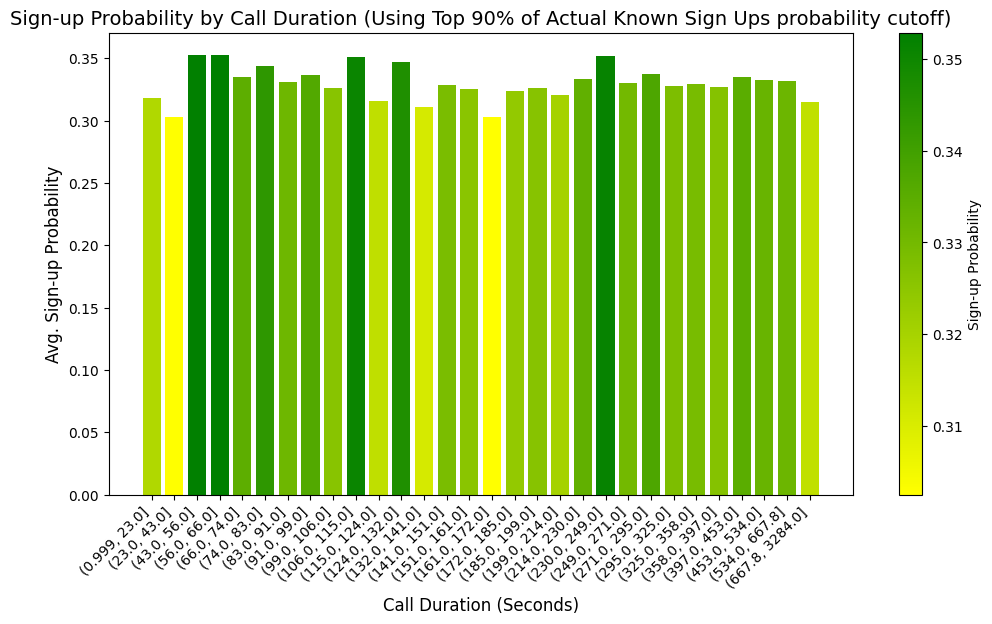


📊 Visualizing Data for: Using Top 50% of Actual Known Sign Ups probability cutoff



C:\Users\cltur\AppData\Local\Temp\ipykernel_13600\852163608.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_prob = df.groupby('duration_bin')['sign_up_probability'].mean().reset_index()


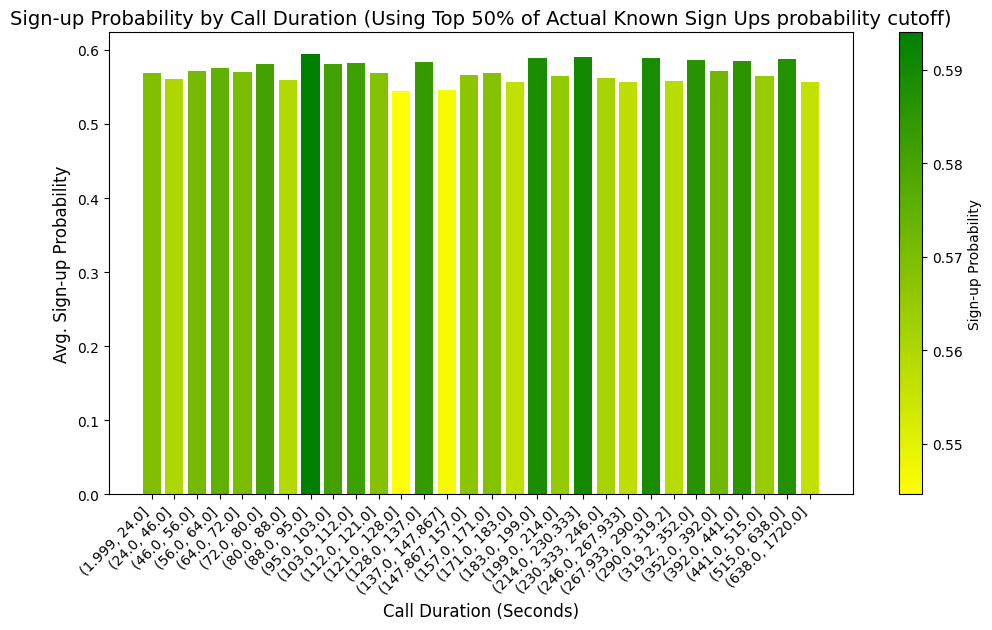


📊 Visualizing Data for: Using Top 20% of Actual Known Sign Ups probability cutoff



C:\Users\cltur\AppData\Local\Temp\ipykernel_13600\852163608.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_prob = df.groupby('duration_bin')['sign_up_probability'].mean().reset_index()


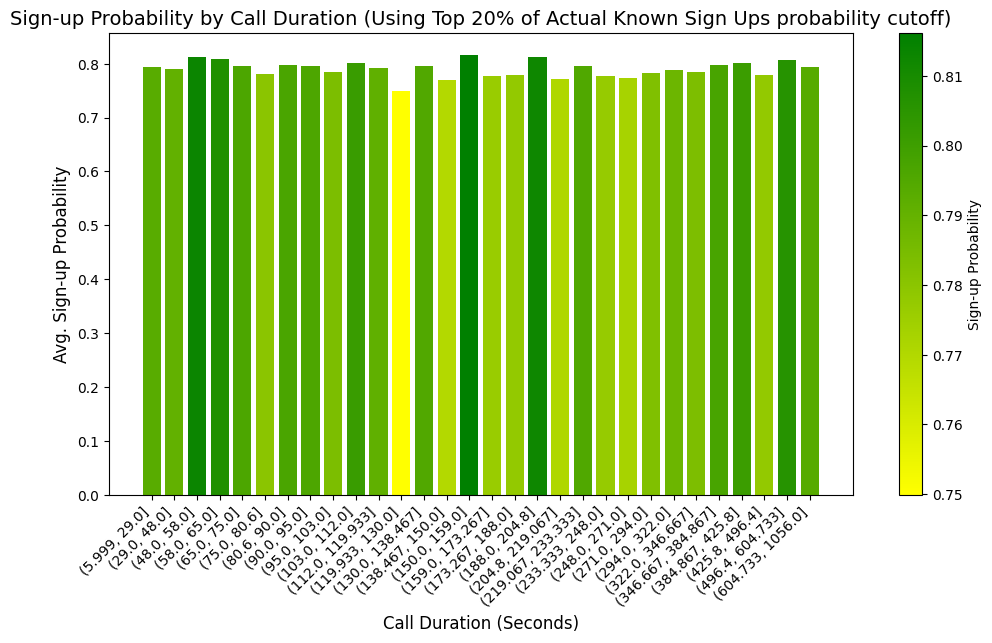

In [181]:
# Visualize duration feature

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define a colormap from yellow (low) to green (high)
custom_cmap = LinearSegmentedColormap.from_list("yellow_to_green", ["yellow", "green"])

# Function to create duration bins
def create_duration_bins(df, duration_col='duration', num_bins=30):
    """
    Bins the 'duration' column into equal-frequency bins.
    """
    df['duration_bin'] = pd.qcut(df[duration_col], q=num_bins, duplicates='drop')
    return df

# Function to create colored bar charts for duration bins
def plot_colored_bar_duration(df, title):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Compute average sign-up probability per duration bin
    avg_prob = df.groupby('duration_bin')['sign_up_probability'].mean().reset_index()

    # Convert interval bins to string for labeling
    avg_prob['duration_bin'] = avg_prob['duration_bin'].astype(str)

    # Normalize probabilities for colormap
    norm = plt.Normalize(vmin=avg_prob['sign_up_probability'].min(),
                         vmax=avg_prob['sign_up_probability'].max())

    # Create x-axis positions
    x_positions = np.arange(len(avg_prob))

    # Use custom colormap
    colors = [custom_cmap(norm(prob)) for prob in avg_prob['sign_up_probability']]

    # Plot bar chart
    bars = ax.bar(x_positions, avg_prob['sign_up_probability'], color=colors, align='center')



    # Set x-ticks to duration bin ranges
    ax.set_xticks(x_positions)
    ax.set_xticklabels(avg_prob['duration_bin'], rotation=45, ha="right")

    # Labels and title
    ax.set_xlabel("Call Duration (Seconds)", fontsize=12)
    ax.set_ylabel("Avg. Sign-up Probability", fontsize=12)
    ax.set_title(title, fontsize=14)

    # Color bar
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Sign-up Probability")

    plt.show()

# Define the dataframes and corresponding titles
dataframes = {
    "Using Top 90% of Actual Known Sign Ups probability cutoff": df_90_layer2_allColumns,
    "Using Top 50% of Actual Known Sign Ups probability cutoff": df_50_layer2_allColumns,
    "Using Top 20% of Actual Known Sign Ups probability cutoff": df_20_layer2_allColumns
}



# Process and plot data for 'duration' feature
for df_name, df in dataframes.items():
    print("\n" + "="*100)  # Creates a visual separator
    print(f"📊 Visualizing Data for: {df_name}")
    print("="*100 + "\n")

    df = create_duration_bins(df)  # Apply duration binning
    plot_colored_bar_duration(df, f"Sign-up Probability by Call Duration ({df_name})")



📊 Visualizing Data for: Using Top 90% of Actual Known Sign Ups probability cutoff



C:\Users\cltur\AppData\Local\Temp\ipykernel_13600\4293235550.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_prob = df.groupby('campaign_bin')['sign_up_probability'].mean().reset_index()


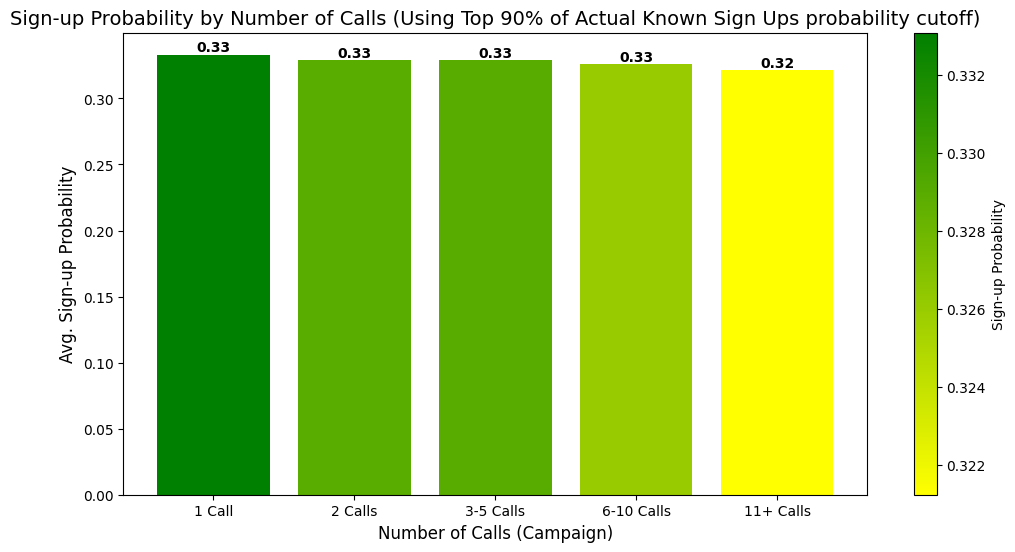


📊 Visualizing Data for: Using Top 50% of Actual Known Sign Ups probability cutoff



C:\Users\cltur\AppData\Local\Temp\ipykernel_13600\4293235550.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_prob = df.groupby('campaign_bin')['sign_up_probability'].mean().reset_index()


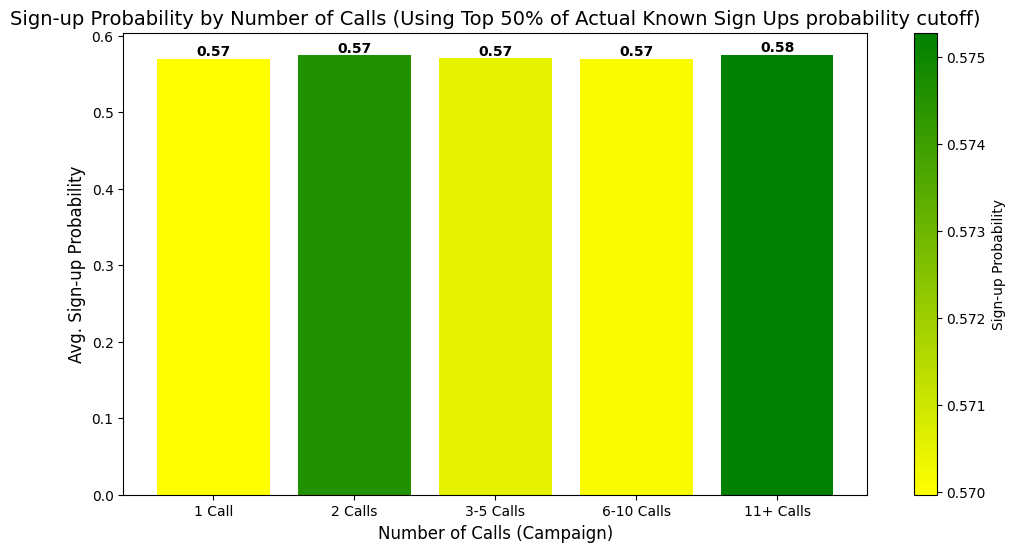


📊 Visualizing Data for: Using Top 20% of Actual Known Sign Ups probability cutoff



C:\Users\cltur\AppData\Local\Temp\ipykernel_13600\4293235550.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_prob = df.groupby('campaign_bin')['sign_up_probability'].mean().reset_index()


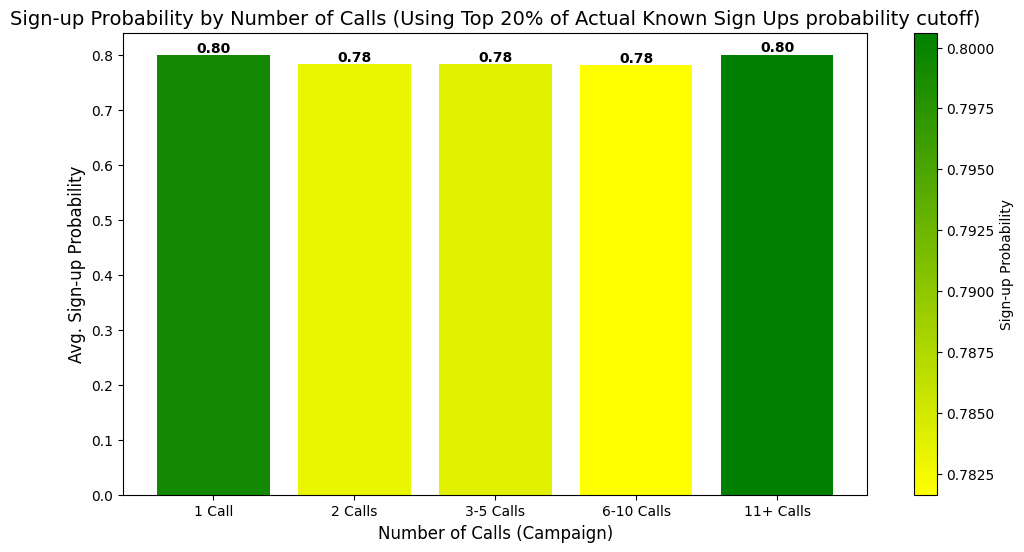

In [180]:
# graphs for campaign

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define a colormap from yellow (low) to green (high)
custom_cmap = LinearSegmentedColormap.from_list("yellow_to_green", ["yellow", "green"])

# Function to create campaign bins
def create_campaign_bins(df, campaign_col='campaign'):
    """
    Bins the 'campaign' column into predefined logical categories.
    """
    bins = [0, 1, 2, 5, 10, np.inf]  # Define breakpoints
    labels = ['1 Call', '2 Calls', '3-5 Calls', '6-10 Calls', '11+ Calls']
    
    df['campaign_bin'] = pd.cut(df[campaign_col], bins=bins, labels=labels, right=True)
    return df

# Function to create colored bar charts for campaign bins
def plot_colored_bar_campaign(df, title):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Compute average sign-up probability per campaign bin
    avg_prob = df.groupby('campaign_bin')['sign_up_probability'].mean().reset_index()

    # Normalize probabilities for colormap
    norm = plt.Normalize(vmin=avg_prob['sign_up_probability'].min(),
                         vmax=avg_prob['sign_up_probability'].max())

    # Create x-axis positions
    x_positions = np.arange(len(avg_prob))

    # Use custom colormap
    colors = [custom_cmap(norm(prob)) for prob in avg_prob['sign_up_probability']]

    # Plot bar chart
    bars = ax.bar(x_positions, avg_prob['sign_up_probability'], color=colors, align='center')

    # Add labels above bars
    for bar, prob in zip(bars, avg_prob['sign_up_probability']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f"{prob:.2f}",
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

    # Set x-ticks to campaign bin labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(avg_prob['campaign_bin'], rotation=0, ha="center")

    # Labels and title
    ax.set_xlabel("Number of Calls (Campaign)", fontsize=12)
    ax.set_ylabel("Avg. Sign-up Probability", fontsize=12)
    ax.set_title(title, fontsize=14)

    # Color bar
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Sign-up Probability")

    plt.show()

# Define the dataframes and corresponding titles
dataframes = {
    "Using Top 90% of Actual Known Sign Ups probability cutoff": df_90_layer2_allColumns,
    "Using Top 50% of Actual Known Sign Ups probability cutoff": df_50_layer2_allColumns,
    "Using Top 20% of Actual Known Sign Ups probability cutoff": df_20_layer2_allColumns
}


# Process and plot data for 'campaign' feature
for df_name, df in dataframes.items():
    print("\n" + "="*100)  # Creates a visual separator
    print(f"📊 Visualizing Data for: {df_name}")
    print("="*100 + "\n")

    df = create_campaign_bins(df)  # Apply campaign binning
    plot_colored_bar_campaign(df, f"Sign-up Probability by Number of Calls ({df_name})")


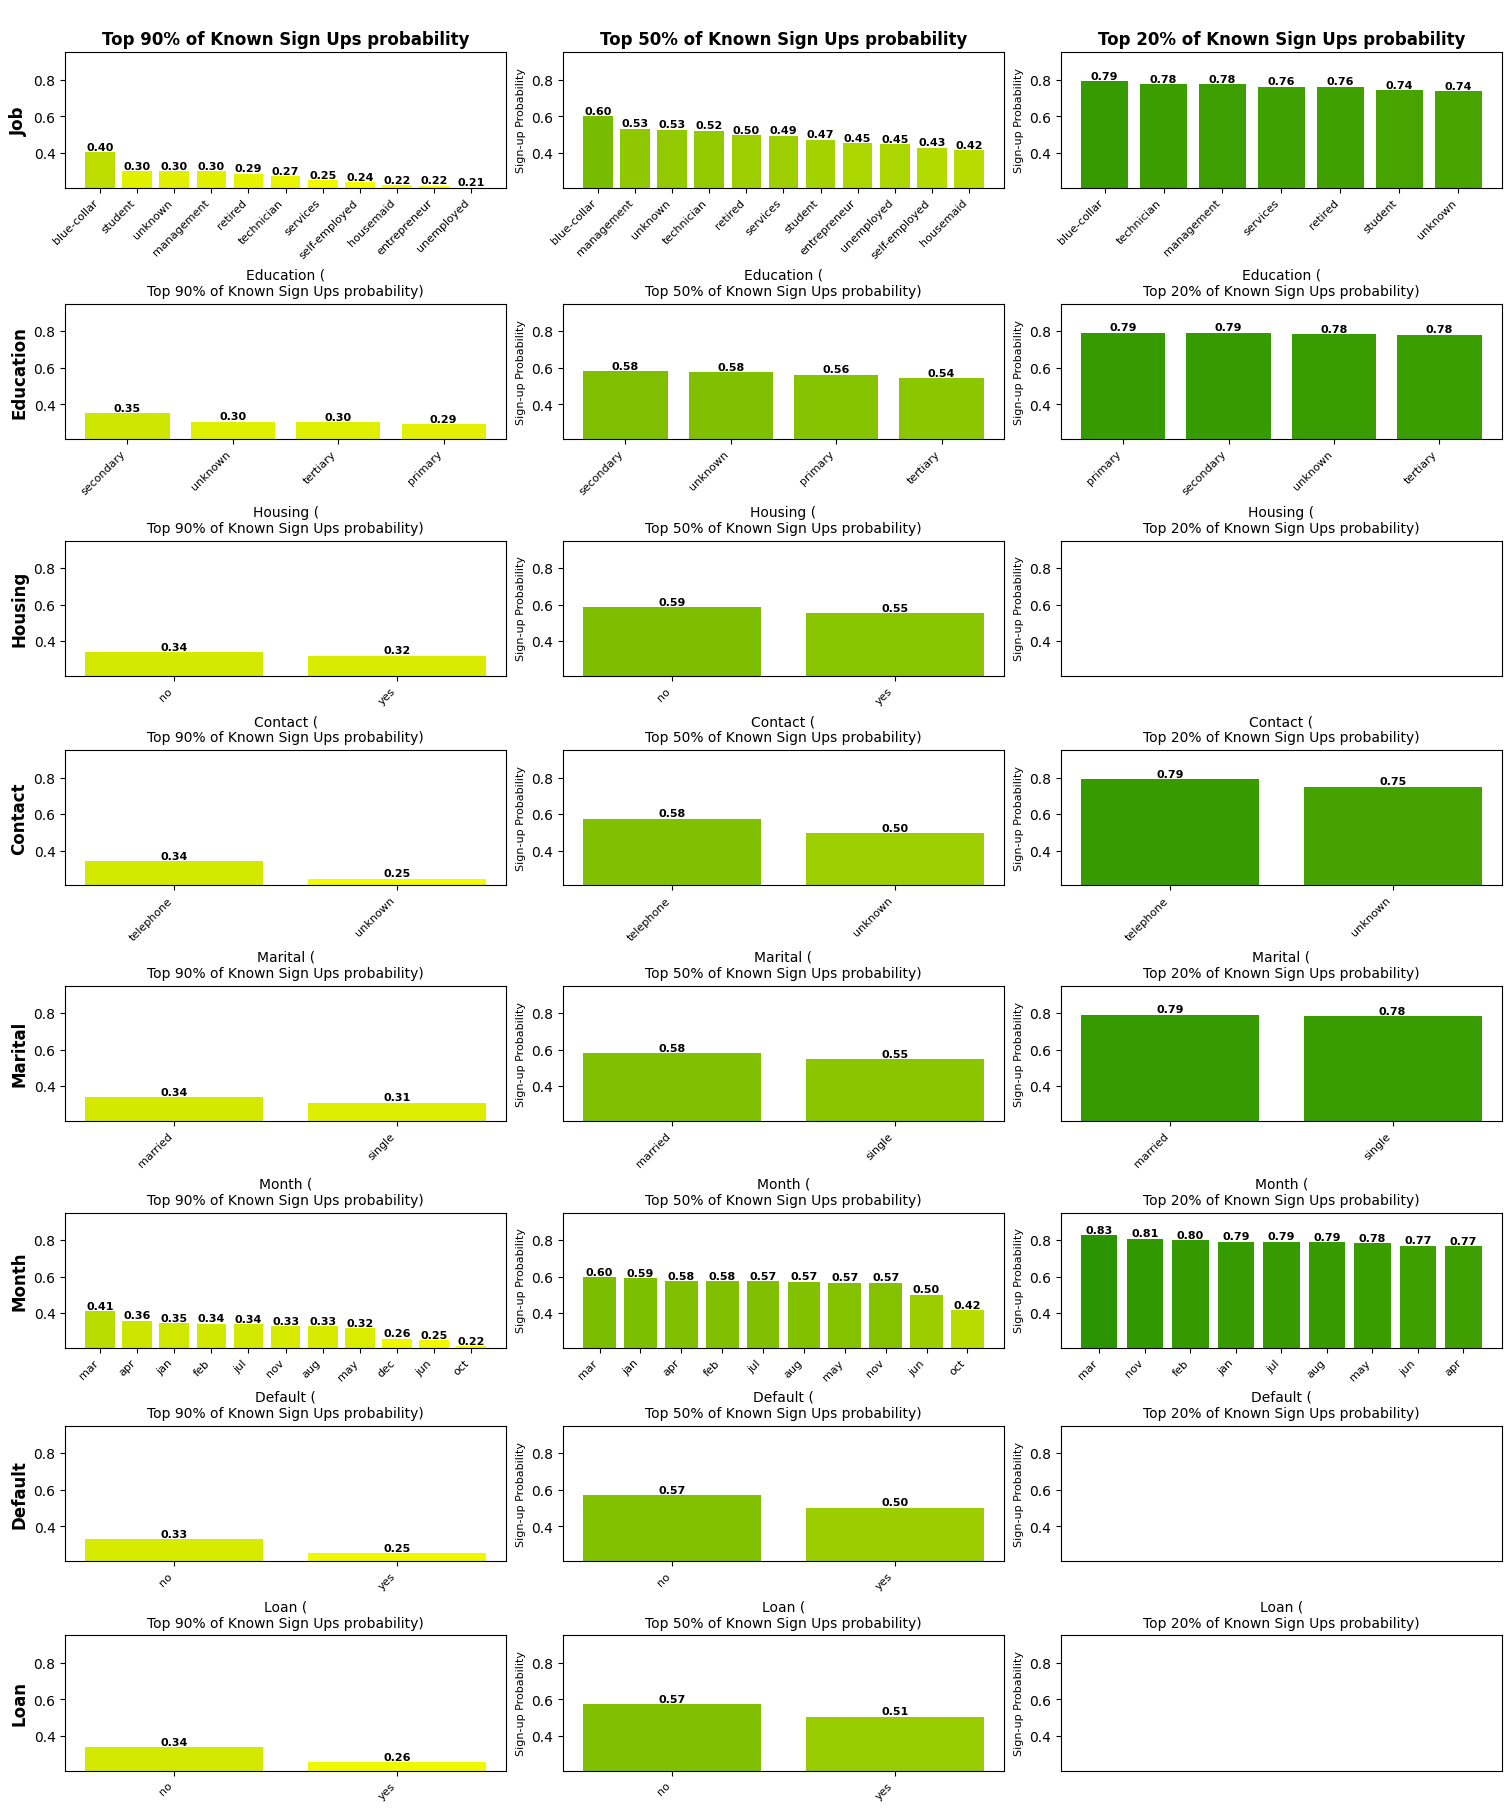

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define a colormap from yellow (low) to green (high)
custom_cmap = LinearSegmentedColormap.from_list("yellow_to_green", ["yellow", "green"])

# Function to create colored bar charts inside a subplot
def plot_colored_bar(ax, df, x_col, title, shared_y_lim):
    # Compute average sign-up probability per category
    avg_prob = df.groupby(x_col)['sign_up_probability'].mean().reset_index()

    # Sort values for better visualization
    avg_prob = avg_prob.sort_values(by='sign_up_probability', ascending=False)

    # Normalize sign-up probabilities for colormap
    norm = plt.Normalize(vmin=shared_y_lim[0], vmax=shared_y_lim[1])

    # Use the custom colormap (Yellow to Green)
    colors = [custom_cmap(norm(prob)) for prob in avg_prob['sign_up_probability']]

    # Plot bar chart
    bars = ax.bar(avg_prob[x_col], avg_prob['sign_up_probability'], color=colors)

    # Add labels above bars
    for bar, prob in zip(bars, avg_prob['sign_up_probability']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f"{prob:.2f}", 
                ha='center', va='bottom', fontsize=8, fontweight='bold', color='black')

    # Set labels and title
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("")  # Remove x-axis label for cleaner look
    ax.set_ylabel("Sign-up Probability", fontsize=8)

    # Set shared y-axis limits
    ax.set_ylim(shared_y_lim)

    # Rotate x-axis labels if needed
    ax.set_xticks(range(len(avg_prob[x_col])))  
    ax.set_xticklabels(avg_prob[x_col], rotation=45, ha="right", fontsize=8)


# Define the dataframes and corresponding titles
dataframes = {
    "\nTop 90% of Known Sign Ups probability": df_90_layer2_allColumns,
    "\nTop 50% of Known Sign Ups probability": df_50_layer2_allColumns,
    "\nTop 20% of Known Sign Ups probability": df_20_layer2_allColumns
}

# List of categorical columns to visualize
categories = ['job', 'education', 'housing', 'contact', 'marital', 'month', 'default', 'loan']

# Compute shared y-axis limits across all datasets
y_min = float("inf")
y_max = float("-inf")

for df in dataframes.values():
    for category in categories:
        avg_prob = df.groupby(category)['sign_up_probability'].mean()
        y_min = min(y_min, avg_prob.min())
        y_max = max(y_max, avg_prob.max())

# Add buffer space (20% of range) to avoid squishing
y_range = y_max - y_min
y_buffer = y_range * 0.2
shared_y_lim = (y_min, y_max + y_buffer)

# Create subplots: rows = categories, cols = different dataframes
fig, axes = plt.subplots(nrows=len(categories), ncols=len(dataframes), figsize=(15, 18), constrained_layout=True)

# Iterate over each category (row)
for row_idx, category in enumerate(categories):
    # Iterate over each dataframe (column)
    for col_idx, (df_name, df) in enumerate(dataframes.items()):
        ax = axes[row_idx, col_idx]  # Select subplot
        plot_colored_bar(ax, df, category, f"{category.capitalize()} ({df_name})", shared_y_lim)

        # Set row labels only for first column
        if col_idx == 0:
            ax.set_ylabel(f"{category.capitalize()}", fontsize=12, fontweight="bold")

        # Set column titles only for first row
        if row_idx == 0:
            ax.set_title(df_name, fontsize=12, fontweight="bold")

# Show all plots in a single figure
plt.show()

In [147]:
import pandas as pd

# Step 1: One-hot encode categorical variables
df_demo = pd.read_csv("../data/raw/term-deposit-marketing-2020.csv")
print(df_demo.columns.tolist())

# Mapping for binary features
binary_columns = {
    'default': {'no': 0, 'yes': 1},
    'housing': {'no': 0, 'yes': 1},
    'loan': {'no': 0, 'yes': 1},
    'y': {'no': 0, 'yes': 1}
}
# Apply the mapping to convert binary columns
for column, mapping in binary_columns.items():
    df_demo[column] = df_demo[column].map(mapping)


df_demo = pd.get_dummies(df_demo, columns=['job', 'marital', 'contact'], prefix=['job', 'marital', 'contact'])

# Ordinal encoding for education
education_mapping = {'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3}
df_demo['education'] = df_demo['education'].map(education_mapping)

print(df_demo.columns.tolist())

# Ordinal encoding for month
month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
df_demo['month'] = df_demo['month'].map(month_mapping)

# Identify missing columns needed for the demographic model
missing_columns = [col for col in demographic_model.feature_names_in_ if col not in df_demo.columns]

# Print missing columns
if missing_columns:
    print("Missing columns:", missing_columns)
else:
    print("All required columns are present.")


# Step 3: Keep only the necessary features
df_demo = df_demo[demographic_model.feature_names_in_]

# Step 4: Predict probability
df_demo['sign_up_probability'] = demographic_model.predict_proba(df_demo)[:, 1]

print(df_demo.columns.tolist())

df_camp = pd.read_csv("../data/raw/term-deposit-marketing-2020.csv")
df_campaign['sign_up_probability'] = df_demo['sign_up_probability']
#df_campaign = df_camp[campaign_model_signUpProbability.feature_names_in_]
print(df_campaign.columns.tolist())
#df_campaign.drop(columns=['y'], inplace=True)

df_campaign.drop(columns=['layer2_sign_up_probability'], inplace=True)
df_campaign['layer2_sign_up_probability'] = campaign_model_signUpProbability.predict_proba(df_campaign)[:, 1]


print(df_campaign.columns.tolist())

df_all = pd.read_csv("../data/raw/term-deposit-marketing-2020.csv")

df_all['sign_up_probability'] = df_campaign['sign_up_probability']
df_all['layer2_sign_up_probability'] = df_campaign['layer2_sign_up_probability']

# Display the first few rows
print(df_campaign.columns.tolist())



['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y']
['age', 'education', 'default', 'balance', 'housing', 'loan', 'day', 'month', 'duration', 'campaign', 'y', 'job_admin', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'contact_cellular', 'contact_telephone', 'contact_unknown']
All required columns are present.
['age', 'education', 'default', 'balance', 'housing', 'loan', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'contact_telephone', 'contact_unknown', 'marital_married', 'marital_single', 'sign_up_probability']
['day', 'month', 'duration', 'campaign', 'sign_

In [148]:
print(df_all.columns.tolist())

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y', 'sign_up_probability', 'layer2_sign_up_probability']


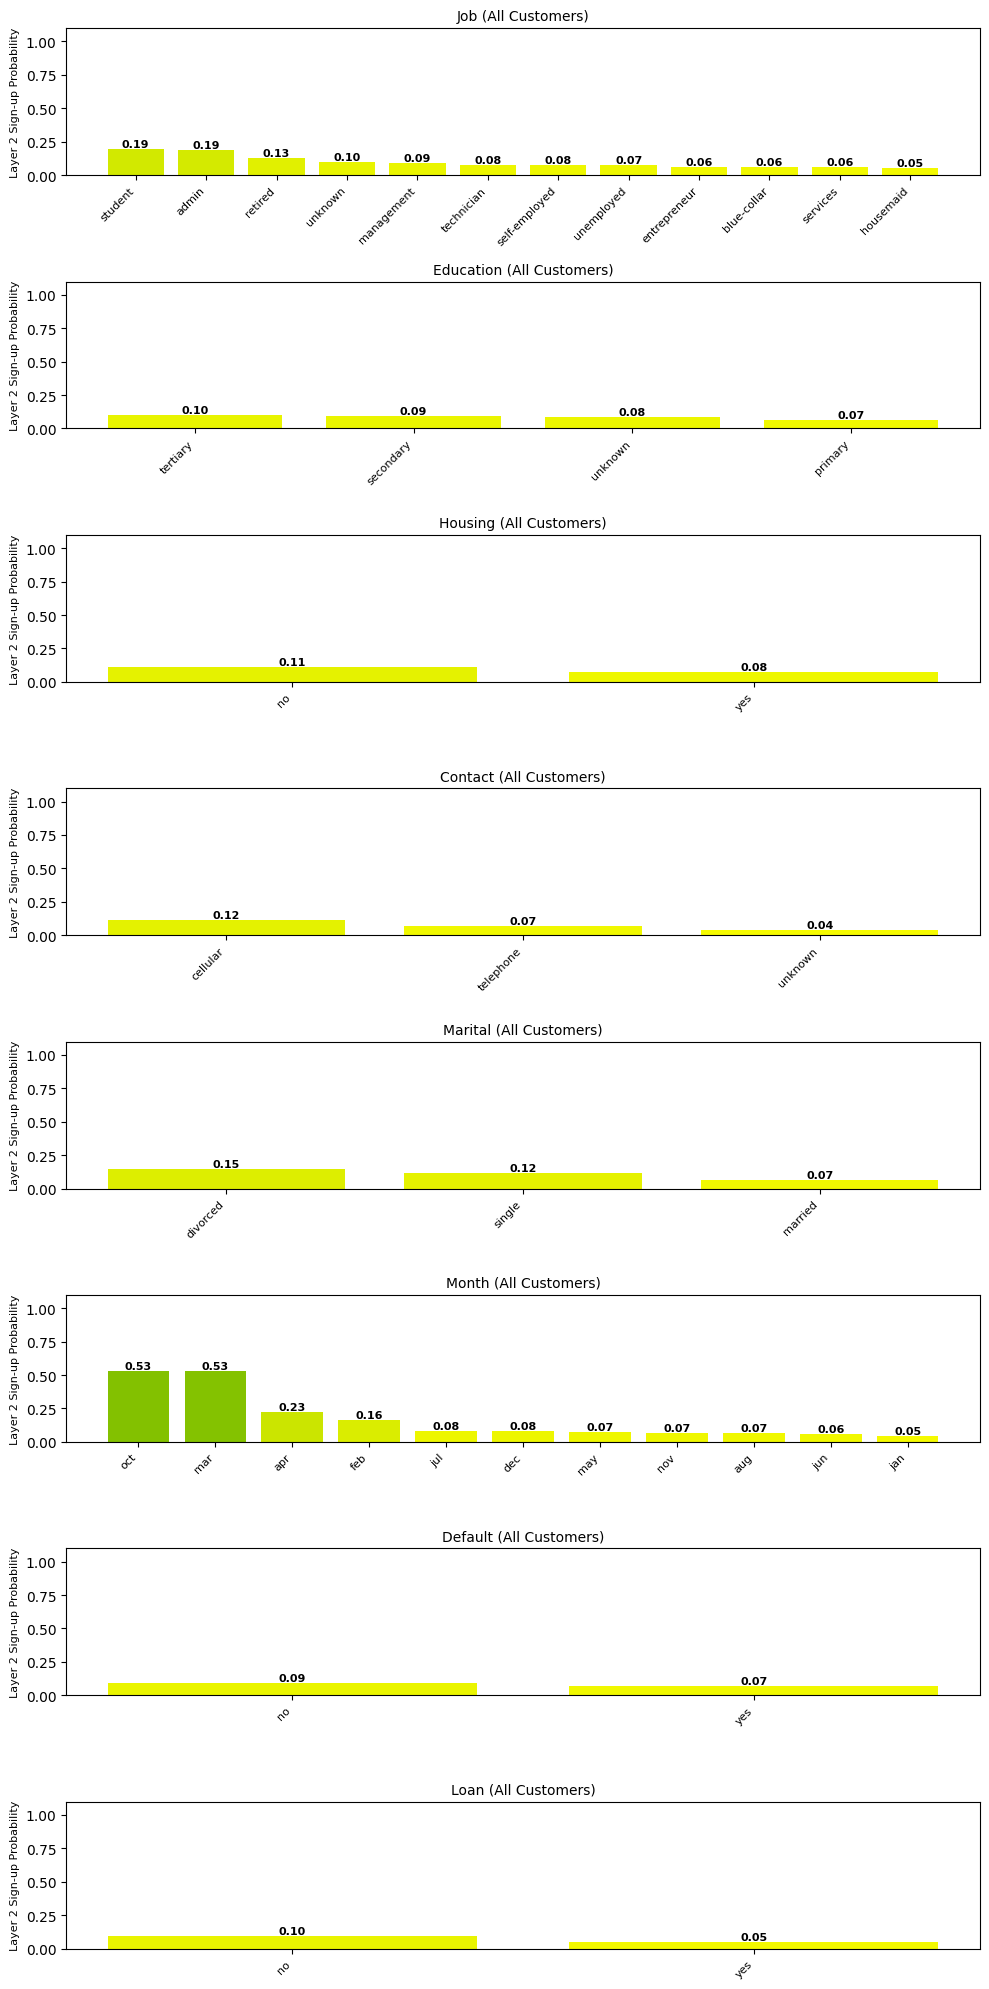

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define a colormap from yellow (low) to green (high)
custom_cmap = LinearSegmentedColormap.from_list("yellow_to_green", ["yellow", "green"])

# Function to create colored bar charts inside a subplot
def plot_colored_bar(ax, df, x_col, title, shared_y_lim):
    # Compute average sign-up probability per category
    avg_prob = df.groupby(x_col)['layer2_sign_up_probability'].mean().reset_index()

    # Sort values for better visualization
    avg_prob = avg_prob.sort_values(by='layer2_sign_up_probability', ascending=False)

    # Normalize sign-up probabilities for colormap
    norm = plt.Normalize(vmin=shared_y_lim[0], vmax=shared_y_lim[1])

    # Use the custom colormap (Yellow to Green)
    colors = [custom_cmap(norm(prob)) for prob in avg_prob['layer2_sign_up_probability']]

    # Plot bar chart
    bars = ax.bar(avg_prob[x_col], avg_prob['layer2_sign_up_probability'], color=colors)

    # Add labels above bars
    for bar, prob in zip(bars, avg_prob['layer2_sign_up_probability']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f"{prob:.2f}", 
                ha='center', va='bottom', fontsize=8, fontweight='bold', color='black')

    # Set labels and title
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("")  # Remove x-axis label for cleaner look
    ax.set_ylabel("Layer 2 Sign-up Probability", fontsize=8)

    # Set shared y-axis limits
    ax.set_ylim(shared_y_lim)

    # Rotate x-axis labels if needed
    ax.set_xticks(range(len(avg_prob[x_col])))  
    ax.set_xticklabels(avg_prob[x_col], rotation=45, ha="right", fontsize=8)


# Define the dataframes and corresponding titles
dataframes = {
    "All Customers": df_all
}

# List of categorical columns to visualize
categories = ['job', 'education', 'housing', 'contact', 'marital', 'month', 'default', 'loan']


# Compute shared y-axis limits across all datasets
y_min = float("inf")
y_max = float("-inf")

for df in dataframes.values():
    for category in categories:
        avg_prob = df.groupby(category)['layer2_sign_up_probability'].mean()
        y_min = min(y_min, avg_prob.min())
        y_max = max(y_max, avg_prob.max())

# Add buffer space (20% of range) to avoid squishing
y_range = y_max - y_min
y_buffer = y_range * 0.2
shared_y_lim = (0, 1 + y_buffer)

# Increase figure height for better readability
fig, axes = plt.subplots(nrows=len(categories), ncols=len(dataframes), figsize=(10, len(categories) * 2.5))  

# If there's only one row or column, ensure axes is a list of lists
if len(categories) == 1:
    axes = [axes]  
if len(dataframes) == 1:
    axes = [[ax] for ax in axes]  

for row_idx, category in enumerate(categories):
    for col_idx, (df_name, df) in enumerate(dataframes.items()):
        ax = axes[row_idx][col_idx]  
        plot_colored_bar(ax, df, category, f"{category.capitalize()} ({df_name})", shared_y_lim)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show all plots in a single figure
plt.show()


In [ ]:
# Save models to models directory

import pickle

# Save the trained model with a new name
layer1_model_filename = "../models/layer1_model.pkl"

with open(layer1_model_filename, "wb") as model_file:
    pickle.dump(demographic_model, model_file)

print(f"Model saved successfully as {layer1_model_filename}!")

# Save the trained model with a new name
layer2_model_filename = "../models/layer2_model.pkl"

with open(layer2_model_filename, "wb") as model_file:
    pickle.dump(campaign_model_signUpProbability, model_file)

print(f"Model saved successfully as {layer2_model_filename}!")




In [ ]:
# Save the sorted and chosen customers to a CSV file for further use
#     For different levels of targeted approach

df_90_layer2_allColumns.to_csv("../results/broad_likelihood_customers.csv", index=False)

df_50_layer2_allColumns.to_csv("../results/focused_likelihood_customers.csv", index=False)

df_20_layer2_allColumns.to_csv("../results/high_confidence_customers.csv", index=False)


In [178]:
df_all.to_csv("../results/all_customers.csv", index=False)